###1. Import Libraries and Setup



In [1]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from PIL import Image
from torchvision import models
import numpy as np
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR

from google.colab import drive
drive.mount('/content/drive',force_remount=True)

# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Mounted at /content/drive
Using device: cuda


### Load Data and Prepare Dataset

In [2]:
"""import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

# Load the DataFrame containing filenames and labels
df = pd.read_csv('/content/drive/MyDrive/Data Science AUEB/Deep Learning/datasets/Other Useful/labeled wavs/final_labels.csv')

# Convert 'Filename' column to string to avoid any type issues
df['Filename'] = df['Filename'].astype(str)

# --- Patient-wise Split Logic (remains unchanged) ---

# 1. Get unique patient IDs and their corresponding diagnosis for stratification
patient_diagnoses = df.groupby('Patient ID')['Diagnosis'].first().reset_index()

# 2. Check the number of samples per diagnosis
diagnosis_counts = patient_diagnoses['Diagnosis'].value_counts()

# Identify diagnoses with fewer than 2 samples (problematic for direct stratified split)
small_classes = diagnosis_counts[diagnosis_counts < 2].index.tolist()

# Initialize lists to store patient IDs for each split
train_patient_ids_list = []
val_patient_ids_list = []
test_patient_ids_list = []

# Handle small classes separately: put them all in the training set
if small_classes:
    small_class_patients_df = patient_diagnoses[patient_diagnoses['Diagnosis'].isin(small_classes)]
    train_patient_ids_list.extend(small_class_patients_df['Patient ID'].tolist())
    # Exclude these patients from the pool for stratified splitting
    patients_for_stratified_pool_df = patient_diagnoses[~patient_diagnoses['Patient ID'].isin(small_class_patients_df['Patient ID'])]
else:
    patients_for_stratified_pool_df = patient_diagnoses.copy()

# Perform the first stratified split (Train vs. Temporary) on the refined pool
train_remaining_ids, temp_remaining_ids = [], []
if not patients_for_stratified_pool_df.empty:
    train_remaining_ids, temp_remaining_ids = train_test_split(
        patients_for_stratified_pool_df['Patient ID'],
        test_size=0.2,   # 20% for temp (validation + test)
        stratify=patients_for_stratified_pool_df['Diagnosis'],
        random_state=42
    )
    train_patient_ids_list.extend(train_remaining_ids.tolist())
    temp_patient_ids_df = patient_diagnoses[patient_diagnoses['Patient ID'].isin(temp_remaining_ids)].copy()
else:
    temp_patient_ids_df = pd.DataFrame() # No patients remaining for temp if pool was empty

# Before the second stratified split, check for small classes in the temporary pool
temp_diagnosis_counts = temp_patient_ids_df['Diagnosis'].value_counts()
small_classes_in_temp = temp_diagnosis_counts[temp_diagnosis_counts < 2].index.tolist()

if small_classes_in_temp:
    small_class_patients_in_temp_df = temp_patient_ids_df[temp_patient_ids_df['Diagnosis'].isin(small_classes_in_temp)]
    # Move these single-instance classes to the validation set
    val_patient_ids_list.extend(small_class_patients_in_temp_df['Patient ID'].tolist())
    # Exclude these patients from the temporary pool for further splitting
    temp_patients_for_split_df = temp_patient_ids_df[~temp_patient_ids_df['Patient ID'].isin(small_class_patients_in_temp_df['Patient ID'])]
else:
    temp_patients_for_split_df = temp_patient_ids_df.copy()

# Perform the second stratified split (Validation vs. Test) on the refined temp pool
val_remaining_ids, test_remaining_ids = [], []
if not temp_patients_for_split_df.empty:
    val_remaining_ids, test_remaining_ids = train_test_split(
        temp_patients_for_split_df['Patient ID'],
        test_size=0.5,   # 50% of temp is for test (10% of total)
        stratify=temp_patients_for_split_df['Diagnosis'],
        random_state=42
    )
    val_patient_ids_list.extend(val_remaining_ids.tolist())
    test_patient_ids_list.extend(test_remaining_ids.tolist())

# Combine initial assignments with stratified split results to get final patient ID lists
final_train_patient_ids = list(set(train_patient_ids_list))
final_val_patient_ids = list(set(val_patient_ids_list))
final_test_patient_ids = list(set(test_patient_ids_list))

# Create the final DataFrames using the split patient IDs
train_df = df[df['Patient ID'].isin(final_train_patient_ids)]
val_df = df[df['Patient ID'].isin(final_val_patient_ids)]
test_df = df[df['Patient ID'].isin(final_test_patient_ids)]

print("--- Initial Split Results (before Augmentation) ---")
print(f"\nTrain: {len(train_df)} samples, Validation: {len(val_df)} samples, Test: {len(test_df)} samples")
print(f"Unique patients in Train set: {len(set(train_df['Patient ID'].unique()))}")
print(f"Unique patients in Validation set: {len(set(val_df['Patient ID'].unique()))}")
print(f"Unique patients in Test set: {len(set(test_df['Patient ID'].unique()))}")
print(f"Overlap between Train and Validation patients: {len(set(train_df['Patient ID'].unique()).intersection(set(val_df['Patient ID'].unique())))}")
print(f"Overlap between Train and Test patients: {len(set(train_df['Patient ID'].unique()).intersection(set(test_df['Patient ID'].unique())))}")
print(f"Overlap between Validation and Test patients: {len(set(val_df['Patient ID'].unique()).intersection(set(test_df['Patient ID'].unique())))}")
print("\nDiagnosis distribution in Train set:")
print(train_df['Diagnosis'].value_counts(normalize=True))
print("\nDiagnosis distribution in Validation set:")
print(val_df['Diagnosis'].value_counts(normalize=True))
print("\nDiagnosis distribution in Test set:")
print(test_df['Diagnosis'].value_counts(normalize=True))

all_diagnoses = patient_diagnoses['Diagnosis'].unique().tolist()
print("\nMissing Diagnoses after Initial Split (Warnings are expected for very rare classes):")
for diagnosis in all_diagnoses:
    if diagnosis not in train_df['Diagnosis'].values:
        print(f"Warning: '{diagnosis}' is missing from Train set.")
    if diagnosis not in val_df['Diagnosis'].values:
        print(f"Warning: '{diagnosis}' is missing from Validation set.")
    if diagnosis not in test_df['Diagnosis'].values:
        print(f"Warning: '{diagnosis}' is missing from Test set.")




## Data Augmentation for Missing Diagnoses


# Function to apply conceptual jittering to a spectrogram array
def jitter_spectrogram(spectrogram_array):
    # Example jittering: adding random Gaussian noise
    # Adjust mean and standard deviation as needed for your specific data
    noise = np.random.normal(0, 0.05, spectrogram_array.shape)
    jittered_spec = spectrogram_array + noise

    # Clip values to be within 0-1 range, as plt.imsave expects this for float images
    jittered_spec = np.clip(jittered_spec, 0, 1)

    return jittered_spec

# Placeholder for spectrogram loading (in a real scenario, you'd load actual spectrogram data)
SPECTROGRAM_DIR = '/content/drive/My Drive/Data Science AUEB/Deep Learning/datasets/Spectrograms/Melspectrograms PNG/'
AUGMENTED_SPECTROGRAM_DIR = '/content/drive/My Drive/Data Science AUEB/Deep Learning/datasets/Spectrograms/Melspectrograms PNG/augmented/' # Directory to save augmented files

# Create the augmented spectrogram directory if it doesn't exist
os.makedirs(AUGMENTED_SPECTROGRAM_DIR, exist_ok=True)

# Function to simulate loading a spectrogram
def load_spectrogram(filename):
    # Ensure the filename ends with '.png' for loading spectrogram images
    if filename.endswith('.wav'):
        filename = filename[:-4]  # Remove '.wav'
    if not filename.endswith('.png'):
        filename += ".png"   # Add '.png' extension if not already present

    # Load and return the spectrogram image
    return plt.imread(os.path.join(SPECTROGRAM_DIR, filename))

# Lists to store augmented data rows (these will be full DataFrame rows)
augmented_val_rows = []
augmented_test_rows = []

# Initialize a global counter for augmented IDs, starting from 1
augmented_id_counter = 0

print("\n--- Starting Data Augmentation Process ---")

# Iterate through all unique diagnoses to identify and augment missing ones
for diagnosis in all_diagnoses:
    # --- Augment for Validation Set ---
    if diagnosis not in val_df['Diagnosis'].values:
        print(f"   Augmenting '{diagnosis}' for Validation set.")
        # Find original files for this diagnosis in the training set to serve as source
        source_files_df = train_df[train_df['Diagnosis'] == diagnosis]

        if not source_files_df.empty:
            num_augmentations = max(5, 10 - len(source_files_df))
            for i in range(num_augmentations):
                augmented_id_counter += 1 # Increment for each new augmented file

                # Pick a random original file entry (full row) from the training set for augmentation
                original_file_entry = source_files_df.sample(1, random_state=42+i).iloc[0]
                original_filename = original_file_entry['Filename']

                # Load original spectrogram (conceptually)
                spec_array = load_spectrogram(original_filename)

                # Apply jittering
                jittered_spec = jitter_spectrogram(spec_array)

                # Create new filename for the augmented sample, keeping base original name
                # and appending '_augmented_X' where X is the continuous ID
                original_filename_base = os.path.splitext(original_filename)[0]
                new_filename_png = f"{original_filename_base}_augmented_{augmented_id_counter}.png"

                # Save jittered_spec to the augmented directory
                plt.imsave(os.path.join(AUGMENTED_SPECTROGRAM_DIR, new_filename_png), jittered_spec)

                # Create a deep copy of the original row to inherit all its values
                augmented_row = original_file_entry.copy()
                # ONLY update the Filename and add the Augmented_ID
                augmented_row['Filename'] = new_filename_png
                augmented_row['Augmented_ID'] = augmented_id_counter
                augmented_row['Type'] = 'Augmented_Val' # Add a type column for traceability

                augmented_val_rows.append(augmented_row)
        else:
            print(f"    No source files for '{diagnosis}' in training set to augment for Validation. This indicates an extremely rare diagnosis.")

    # --- Augment for Test Set (similar logic to validation) ---
    if diagnosis not in test_df['Diagnosis'].values:
        print(f"   Augmenting '{diagnosis}' for Test set.")
        source_files_df = train_df[train_df['Diagnosis'] == diagnosis]

        if not source_files_df.empty:
            num_augmentations = max(5, 10 - len(source_files_df))
            for i in range(num_augmentations):
                augmented_id_counter += 1 # Increment for each new augmented file

                original_file_entry = source_files_df.sample(1, random_state=42+i+num_augmentations).iloc[0]
                original_filename = original_file_entry['Filename']

                spec_array = load_spectrogram(original_filename)
                jittered_spec = jitter_spectrogram(spec_array)

                original_filename_base = os.path.splitext(original_filename)[0]
                new_filename_png = f"{original_filename_base}_augmented_{augmented_id_counter}.png"

                plt.imsave(os.path.join(AUGMENTED_SPECTROGRAM_DIR, new_filename_png), jittered_spec)

                # Create a deep copy of the original row to inherit all its values
                augmented_row = original_file_entry.copy()
                # ONLY update the Filename and add the Augmented_ID
                augmented_row['Filename'] = new_filename_png
                augmented_row['Augmented_ID'] = augmented_id_counter
                augmented_row['Type'] = 'Augmented_Test' # Add a type column for traceability

                augmented_test_rows.append(augmented_row)
        else:
            print(f"    No source files for '{diagnosis}' in training set to augment for Test. This indicates an extremely rare diagnosis.")

# Convert lists of augmented rows into DataFrames
augmented_val_df = pd.DataFrame(augmented_val_rows)
augmented_test_df = pd.DataFrame(augmented_test_rows)

# Ensure new columns ('Augmented_ID', 'Type') exist in original DFs before concatenation
# Fill them with NaN for original data, as they only apply to augmented data.
for col in ['Augmented_ID', 'Type']:
    if col not in train_df.columns:
        train_df[col] = np.nan
    if col not in val_df.columns:
        val_df[col] = np.nan
    if col not in test_df.columns:
        test_df[col] = np.nan

# Assign 'Type' for original dataframes for clarity
train_df['Type'] = 'Original_Train'
val_df['Type'] = 'Original_Val'
test_df['Type'] = 'Original_Test'


# Concatenate augmented data with original validation and test sets
# Pandas will align columns by name, ensuring full metadata is preserved.
val_df_final = pd.concat([val_df, augmented_val_df], ignore_index=True)
test_df_final = pd.concat([test_df, augmented_test_df], ignore_index=True)


## Verification After Augmentation


print("\n--- Verification After Augmentation ---")
print(f"\nAugmented Validation Set: {len(val_df_final)} samples")
print(f"Augmented Test Set: {len(test_df_final)} samples")

print("\nDiagnosis distribution in Final Validation set:")
print(val_df_final['Diagnosis'].value_counts(normalize=True))
print("\nDiagnosis distribution in Final Test set:")
print(test_df_final['Diagnosis'].value_counts(normalize=True))

print("\nFinal check for missing diagnoses after augmentation:")
for diagnosis in all_diagnoses:
    if diagnosis not in val_df_final['Diagnosis'].values:
        print(f"Warning: '{diagnosis}' is STILL missing from Final Validation set. (This implies an issue with source data in train_df).")
    if diagnosis not in test_df_final['Diagnosis'].values:
        print(f"Warning: '{diagnosis}' is STILL missing from Final Test set. (This implies an issue with source data in train_df).")

# You would now use `train_df`, `val_df_final`, and `test_df_final` for your deep learning model training and evaluation.
train_df.to_csv('/content/drive/MyDrive/Data Science AUEB/Deep Learning/datasets/Other Useful/labeled wavs/train_df.csv', index=False)
val_df_final.to_csv('/content/drive/MyDrive/Data Science AUEB/Deep Learning/datasets/Other Useful/labeled wavs/val_df.csv', index=False)
test_df_final.to_csv('/content/drive/MyDrive/Data Science AUEB/Deep Learning/datasets/Other Useful/labeled wavs/test_df.csv', index=False)"""

'import pandas as pd\nimport numpy as np\nimport matplotlib.pyplot as plt\nimport os\nfrom sklearn.model_selection import train_test_split\n\n# Load the DataFrame containing filenames and labels\ndf = pd.read_csv(\'/content/drive/MyDrive/Data Science AUEB/Deep Learning/datasets/Other Useful/labeled wavs/final_labels.csv\')\n\n# Convert \'Filename\' column to string to avoid any type issues\ndf[\'Filename\'] = df[\'Filename\'].astype(str)\n\n# --- Patient-wise Split Logic (remains unchanged) ---\n\n# 1. Get unique patient IDs and their corresponding diagnosis for stratification\npatient_diagnoses = df.groupby(\'Patient ID\')[\'Diagnosis\'].first().reset_index()\n\n# 2. Check the number of samples per diagnosis\ndiagnosis_counts = patient_diagnoses[\'Diagnosis\'].value_counts()\n\n# Identify diagnoses with fewer than 2 samples (problematic for direct stratified split)\nsmall_classes = diagnosis_counts[diagnosis_counts < 2].index.tolist()\n\n# Initialize lists to store patient IDs for eac

In [3]:
import pandas as pd

# Load the DataFrames
train_df = pd.read_csv('/content/drive/MyDrive/Data Science AUEB/Deep Learning/datasets/Other Useful/labeled wavs/train_df.csv')
val_df = pd.read_csv('/content/drive/MyDrive/Data Science AUEB/Deep Learning/datasets/Other Useful/labeled wavs/val_df.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Data Science AUEB/Deep Learning/datasets/Other Useful/labeled wavs/test_df.csv')


In [4]:
train_df

,WAV File ID,Patient ID,Filename,Diagnosis,Domain,Domain_ID,Augmented_ID,Type
0,1.0,1.0,101_1b1_Al_sc_Meditron.wav,URTI,ICBHI,0,NaN,Original_Train
1,2.0,1.0,101_1b1_Pr_sc_Meditron.wav,URTI,ICBHI,0,NaN,Original_Train
2,3.0,2.0,102_1b1_Ar_sc_Meditron.wav,Healthy,ICBHI,0,NaN,Original_Train
3,4.0,3.0,103_2b2_Ar_mc_LittC2SE.wav,Asthma,ICBHI,0,NaN,Original_Train
4,5.0,4.0,104_1b1_Al_sc_Litt3200.wav,COPD,ICBHI,0,NaN,Original_Train
...,...,...,...,...,...,...,...,...
9777,475.0,64.0,164_1b1_Ll_sc_Meditron_snippet_4.wav_stretch_0...,URTI,ICBHI,0,NaN,Original_Train
9778,475.0,64.0,164_1b1_Ll_sc_Meditron_snippet_4.wav_stretch_0...,URTI,ICBHI,0,NaN,Original_Train
9779,475.0,64.0,164_1b1_Ll_sc_Meditron_snippet_4.wav_pitch_-2.wav,URTI,ICBHI,0,NaN,Original_Train
9780,475.0,64.0,164_1b1_Ll_sc_Meditron_snippet_4.wav_pitch_1.wav,URTI,ICBHI,0,NaN,Original_Train


In [5]:
val_df

,WAV File ID,Patient ID,Filename,Diagnosis,Domain,Domain_ID,Augmented_ID,Type
0,12.0,6.0,106_2b1_Pl_mc_LittC2SE.wav,COPD,ICBHI,0,NaN,Original_Val
1,13.0,6.0,106_2b1_Pr_mc_LittC2SE.wav,COPD,ICBHI,0,NaN,Original_Val
2,72.0,15.0,115_1b1_Ar_sc_Meditron.wav,LRTI,ICBHI,0,NaN,Original_Val
3,83.0,19.0,119_1b1_Ar_sc_Meditron.wav,URTI,ICBHI,0,NaN,Original_Val
4,178.0,31.0,131_1b1_Al_sc_Meditron.wav,URTI,ICBHI,0,NaN,Original_Val
...,...,...,...,...,...,...,...,...
1376,944.0,134.0,"DP8_Plueral Effusion,I C B,P L L,70,M_snippet_...",Pleural Effusion,KAUH,1,16.0,Augmented_Val
1377,943.0,134.0,"EP8_Plueral Effusion,I C B,P L L,70,M_snippet_...",Pleural Effusion,KAUH,1,17.0,Augmented_Val
1378,942.0,134.0,"BP8_Plueral Effusion,I C B,P L L,70,M_snippet_...",Pleural Effusion,KAUH,1,18.0,Augmented_Val
1379,937.0,132.0,"DP6_Plueral Effusion,I C B,P L R,81,M_snippet_...",Pleural Effusion,KAUH,1,19.0,Augmented_Val


In [6]:
test_df

,WAV File ID,Patient ID,Filename,Diagnosis,Domain,Domain_ID,Augmented_ID,Type
0,11.0,5.0,105_1b1_Tc_sc_Meditron.wav,URTI,ICBHI,0,NaN,Original_Test
1,14.0,7.0,107_2b3_Al_mc_AKGC417L.wav,COPD,ICBHI,0,NaN,Original_Test
2,15.0,7.0,107_2b3_Ar_mc_AKGC417L.wav,COPD,ICBHI,0,NaN,Original_Test
3,16.0,7.0,107_2b3_Ll_mc_AKGC417L.wav,COPD,ICBHI,0,NaN,Original_Test
4,17.0,7.0,107_2b3_Lr_mc_AKGC417L.wav,COPD,ICBHI,0,NaN,Original_Test
...,...,...,...,...,...,...,...,...
1200,944.0,134.0,"DP8_Plueral Effusion,I C B,P L L,70,M_snippet_...",Pleural Effusion,KAUH,1,21.0,Augmented_Test
1201,938.0,132.0,"BP6_Plueral Effusion,I C B,P L R,81,M_snippet_...",Pleural Effusion,KAUH,1,22.0,Augmented_Test
1202,937.0,132.0,"DP6_Plueral Effusion,I C B,P L R,81,M_snippet_...",Pleural Effusion,KAUH,1,23.0,Augmented_Test
1203,938.0,132.0,"BP6_Plueral Effusion,I C B,P L R,81,M_snippet_...",Pleural Effusion,KAUH,1,24.0,Augmented_Test


In [7]:

# Check the split
print(f"\nTrain: {len(train_df)} samples, Validation: {len(val_df)} samples, Test: {len(test_df)} samples")

# Verify that no patient IDs overlap between sets
train_patients = set(train_df['Patient ID'].unique())
val_patients = set(val_df['Patient ID'].unique())
test_patients = set(test_df['Patient ID'].unique())

print(f"\nUnique patients in Train set: {len(train_patients)}")
print(f"Unique patients in Validation set: {len(val_patients)}")
print(f"Unique patients in Test set: {len(test_patients)}")

"""print(f"\nOverlap between Train and Validation patients: {len(train_patients.intersection(val_patients))}")
print(f"Overlap between Train and Test patients: {len(train_patients.intersection(test_patients))}")
print(f"Overlap between Validation and Test patients: {len(val_patients.intersection(test_patients))}")
"""
# Verify stratification by diagnosis in each set (optional, but good for checks)
print("\nDiagnosis distribution in Train set:")
print(train_df['Diagnosis'].value_counts(normalize=True))
print("\nDiagnosis distribution in Validation set:")
print(val_df['Diagnosis'].value_counts(normalize=True))
print("\nDiagnosis distribution in Test set:")
print(test_df['Diagnosis'].value_counts(normalize=True))

# Ensure all diagnoses are included in each set (even if some have only one sample)
diagnosis_counts = train_df['Diagnosis'].value_counts()  # Using train_df as the source for all diagnoses

for diagnosis in diagnosis_counts.index:
    if diagnosis not in train_df['Diagnosis'].values:
        print(f"Warning: '{diagnosis}' is missing from Train set.")
    if diagnosis not in val_df['Diagnosis'].values:
        print(f"Warning: '{diagnosis}' is missing from Validation set.")
    if diagnosis not in test_df['Diagnosis'].values:
        print(f"Warning: '{diagnosis}' is missing from Test set.")



Train: 9782 samples, Validation: 1381 samples, Test: 1205 samples

Unique patients in Train set: 196
Unique patients in Validation set: 28
Unique patients in Test set: 32

Diagnosis distribution in Train set:
Diagnosis
Healthy             0.326927
Asthma              0.235024
Pneumonia           0.125230
COPD                0.103149
URTI                0.063382
Bronchiectasis      0.046616
Lung Fibrosis       0.034962
Bronchiolitis       0.034860
Pleural Effusion    0.026682
LRTI                0.003169
Name: proportion, dtype: float64

Diagnosis distribution in Validation set:
Diagnosis
Healthy             0.360608
Bronchiectasis      0.156408
Asthma              0.123823
COPD                0.097755
Pneumonia           0.089066
Lung Fibrosis       0.056481
Bronchiolitis       0.044895
URTI                0.044895
LRTI                0.022448
Pleural Effusion    0.003621
Name: proportion, dtype: float64

Diagnosis distribution in Test set:
Diagnosis
Healthy             0.360166
Pneum

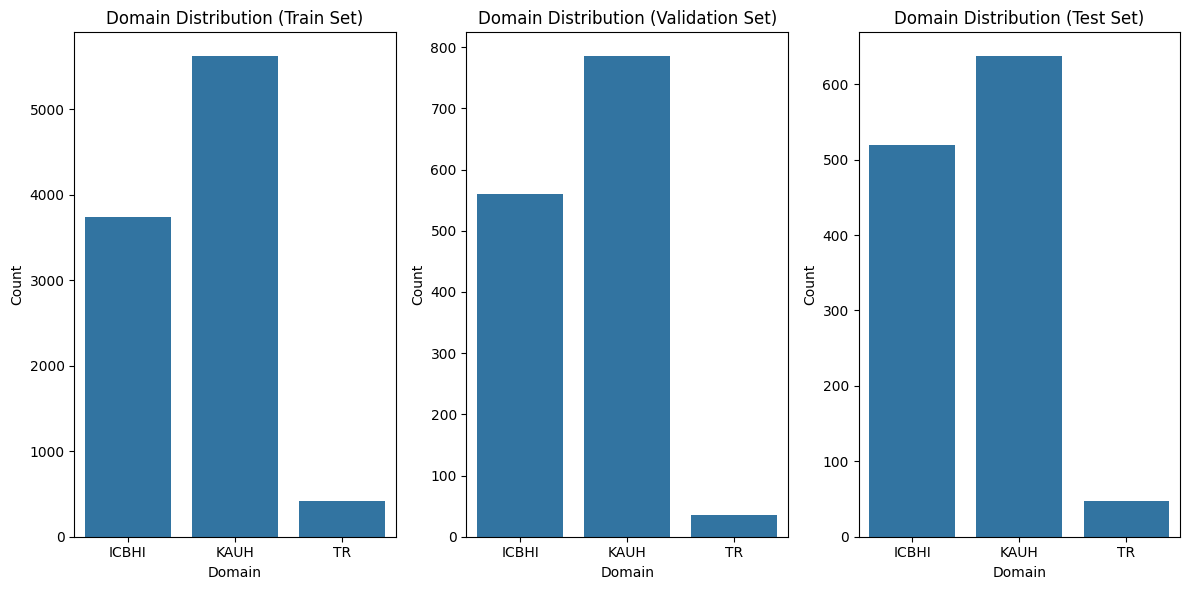


Number of Unique Patients per Diagnosis in Train Set:
          Diagnosis  Patient ID
0            Asthma          19
1    Bronchiectasis           8
2     Bronchiolitis           5
3              COPD          92
4           Healthy          45
5              LRTI           1
6     Lung Fibrosis           4
7  Pleural Effusion           2
8         Pneumonia           9
9              URTI          11

Number of Unique Patients per Diagnosis in Validation Set:
          Diagnosis  Patient ID
0            Asthma           2
1    Bronchiectasis           1
2     Bronchiolitis           1
3              COPD          12
4           Healthy           5
5              LRTI           1
6     Lung Fibrosis           1
7  Pleural Effusion           2
8         Pneumonia           1
9              URTI           2

Number of Unique Patients per Diagnosis in Test Set:
          Diagnosis  Patient ID
0            Asthma           3
1    Bronchiectasis           1
2     Bronchiolitis           2

<ipython-input-8-3972218409>:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")  # Rotate x-axis labels for Train plot
<ipython-input-8-3972218409>:59: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")  # Rotate x-axis labels for Validation plot
<ipython-input-8-3972218409>:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha="right")  # Rotate x-axis labels for Test plot


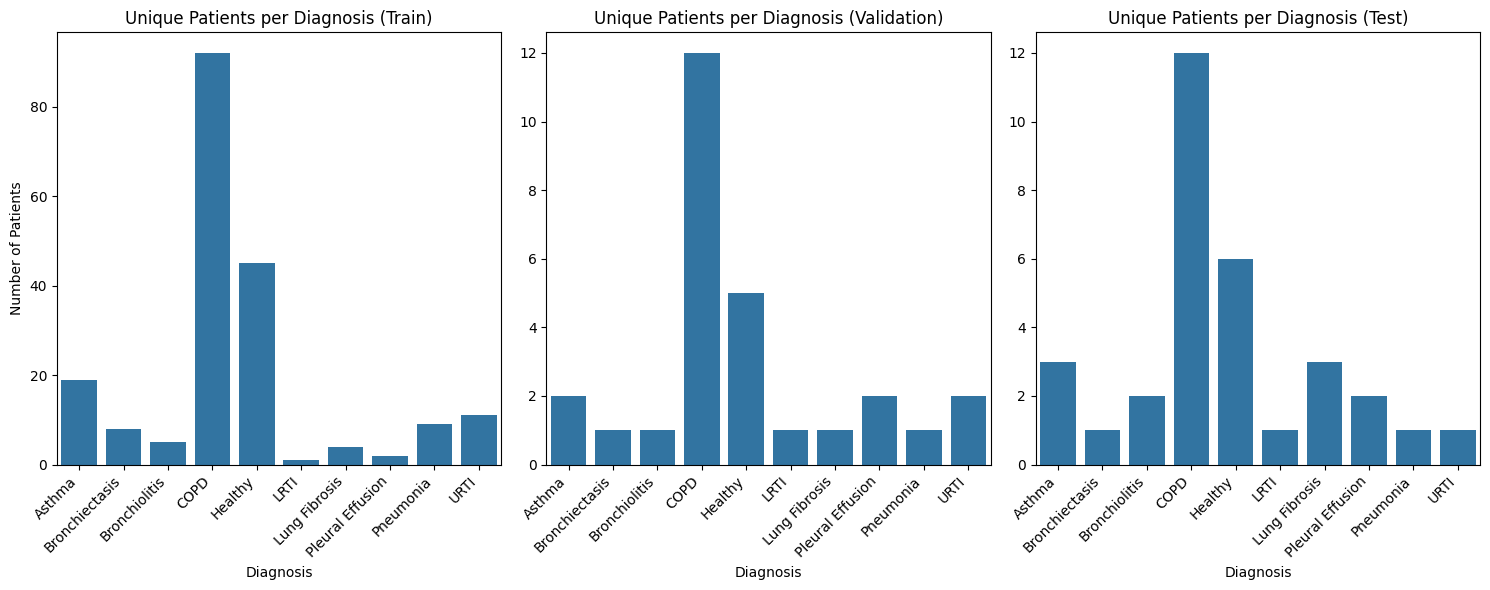

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Analysis of Data Distribution Across Domains ---

# Plotting the distribution of Diagnosis in each set
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
sns.countplot(x='Domain', data=train_df)
plt.title('Domain Distribution (Train Set)')
plt.xlabel('Domain')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
sns.countplot(x='Domain', data=val_df)
plt.title('Domain Distribution (Validation Set)')
plt.xlabel('Domain')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
sns.countplot(x='Domain', data=test_df)
plt.title('Domain Distribution (Test Set)')
plt.xlabel('Domain')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Plotting the distribution of Patient IDs per Diagnosis in each set
# This is more complex and might require a different visualization approach
# Here's a simplified approach showing the number of unique patients per diagnosis per set

patient_diagnosis_counts_train = train_df.groupby('Diagnosis')['Patient ID'].nunique().reset_index()
patient_diagnosis_counts_val = val_df.groupby('Diagnosis')['Patient ID'].nunique().reset_index()
patient_diagnosis_counts_test = test_df.groupby('Diagnosis')['Patient ID'].nunique().reset_index()

print("\nNumber of Unique Patients per Diagnosis in Train Set:")
print(patient_diagnosis_counts_train)
print("\nNumber of Unique Patients per Diagnosis in Validation Set:")
print(patient_diagnosis_counts_val)
print("\nNumber of Unique Patients per Diagnosis in Test Set:")
print(patient_diagnosis_counts_test)

fig, axes = plt.subplots(1, 3, figsize=(15, 6))

# Plot for Train
sns.barplot(x='Diagnosis', y='Patient ID', data=patient_diagnosis_counts_train, ax=axes[0])
axes[0].set_title('Unique Patients per Diagnosis (Train)')
axes[0].set_ylabel('Number of Patients')
axes[0].tick_params(axis='x', labelsize=10)  # Set the size of the x-axis labels
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")  # Rotate x-axis labels for Train plot

# Plot for Validation
sns.barplot(x='Diagnosis', y='Patient ID', data=patient_diagnosis_counts_val, ax=axes[1])
axes[1].set_title('Unique Patients per Diagnosis (Validation)')
axes[1].set_ylabel('')  # Hide y-label for subplots 2 and 3
axes[1].tick_params(axis='x', labelsize=10)  # Set the size of the x-axis labels
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")  # Rotate x-axis labels for Validation plot

# Plot for Test
sns.barplot(x='Diagnosis', y='Patient ID', data=patient_diagnosis_counts_test, ax=axes[2])
axes[2].set_title('Unique Patients per Diagnosis (Test)')
axes[2].set_ylabel('')  # Hide y-label for subplots 2 and 3
axes[2].tick_params(axis='x', labelsize=10)  # Set the size of the x-axis labels
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=45, ha="right")  # Rotate x-axis labels for Test plot

# Display the plot
plt.tight_layout()
plt.show()


### Custom Dataset Class for Lung Sound Spectrograms

### Data Transforms and DataLoader

In [9]:
import os
from PIL import Image

class LungSoundDataset(Dataset):
    def __init__(self, df, img_dir, transform=None):
        """
        Args:
            df (DataFrame): DataFrame containing filenames and labels.
            img_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.df = df
        self.img_dir = img_dir
        self.transform = transform

        # Dynamically create the class label mapping based on unique diagnoses
        self.class_mapping = {
            'Asthma': 0, 'Lung Fibrosis': 1, 'Healthy': 2, 'Pneumonia': 3,
            'Bronchiolitis': 4, 'COPD': 5, 'URTI': 6, 'Pleural Effusion': 7,
            'Bronchiectasis': 8, 'LRTI': 9
        }

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        filename = self.df.iloc[idx]['Filename']

        # Remove the '.wav' extension from the filename
        filename_no_extension = os.path.splitext(filename)[0]

        label = self.df.iloc[idx]['Diagnosis']

        # Construct the full image path (assuming images are named after the filenames without extensions)
        img_path = os.path.join(self.img_dir, f"{filename_no_extension}.png")

        # Check if the file exists before trying to open it
        if not os.path.exists(img_path):
            print(f"Error opening file: {img_path}")
            return None  # Skip this item if the file doesn't exist

        # Open the image and convert it
        image = Image.open(img_path).convert('RGB')

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image)

        # Return the image and its corresponding label
        return image, self.class_mapping.get(label, -1)  # -1 for unknown labels
from sklearn.utils.class_weight import compute_class_weight
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Pretrained model norms
])

# Define paths
img_dir = '/content/drive/My Drive/Data Science AUEB/Deep Learning/datasets/Spectrograms/Melspectrograms PNG'

# Create the datasets and dataloaders
train_dataset = LungSoundDataset(train_df, img_dir, transform)
val_dataset = LungSoundDataset(val_df, img_dir, transform)
test_dataset = LungSoundDataset(test_df, img_dir, transform)

# Optimizing DataLoader with more workers for faster data loading
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=8, pin_memory=True)

# --- Calculate class weights ---
class_weights = compute_class_weight(
    'balanced',
    classes=train_df['Diagnosis'].unique(),
    y=train_df['Diagnosis']
)
weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)


### Model Definitions

#### Custom CNN (Baseline)

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
from tqdm.auto import tqdm
import pandas as pd # Already imported in original file, keeping for context
from sklearn.metrics import accuracy_score # Already imported, keeping for context
from torchvision import models as tv_models # <--- Changed here to use an alias

# Define the CORAL loss function
def coral_loss(source_features, target_features):
    """
    Calculates the CORAL loss between source and target features.

    Args:
        source_features (torch.Tensor): Features from the source domain.
        target_features (torch.Tensor): Features from the target domain.

    Returns:
        torch.Tensor: The CORAL loss.
    """
    # Ensure features are 2D (batch_size, feature_dim)
    source_features = source_features.view(source_features.size(0), -1)
    target_features = target_features.view(target_features.size(0), -1)

    # Center the features
    source_centered = source_features - torch.mean(source_features, dim=0)
    target_centered = target_features - torch.mean(target_features, dim=0)

    # Calculate covariance matrices
    # Add a small epsilon for numerical stability to prevent singular matrices
    epsilon = 1e-5
    source_cov = (source_centered.T @ source_centered) / (source_features.size(0) - 1) + epsilon * torch.eye(source_features.size(1), device=source_features.device)
    target_cov = (target_centered.T @ target_centered) / (target_features.size(0) - 1) + epsilon * torch.eye(target_features.size(1), device=target_features.device)

    # Calculate Frobenius norm of the difference
    loss = torch.norm(source_cov - target_cov, p='fro')

    return loss

# --- Modified Model Definitions with extract_features methods ---

class CustomCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        # Assuming input size is 224x224 after transforms.Resize
        # Calculation for flattened size after three pooling layers: 224 / 2 / 2 / 2 = 28
        self.feature_dim = 128 * 28 * 28
        self.fc1 = nn.Linear(self.feature_dim, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        # This is the standard forward pass for classification
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        features = x.view(-1, self.feature_dim)  # Flattened features
        x = F.relu(self.fc1(features))
        x = self.fc2(x)
        return x

    def extract_features(self, x):
        # This method returns the features before the final classification head
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        features = x.view(-1, self.feature_dim)
        return features



### Pretrained Models (ResNet50, DenseNet121)



In [11]:
class ResNet50_Features(nn.Module):
    def __init__(self, num_classes=10, pretrained=True):
        super(ResNet50_Features, self).__init__()
        resnet = tv_models.resnet50(pretrained=pretrained)
        # Remove the final classification layer to get features
        self.features = nn.Sequential(*list(resnet.children())[:-1]) # Takes all layers except the last fc layer

        # Add a new classification head that matches our number of classes
        num_ftrs = resnet.fc.in_features
        self.classifier = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        # Pass through feature extractor
        features = self.features(x)
        features = torch.flatten(features, 1) # Flatten the features for the classifier

        # Pass through classifier
        output = self.classifier(features)
        return output

    def extract_features(self, x):
        # Returns features before the final classification head
        features = self.features(x)
        features = torch.flatten(features, 1)
        return features

class DenseNet121_Features(nn.Module):
    def __init__(self, num_classes=10, pretrained=True):
        super(DenseNet121_Features, self).__init__()
        densenet = tv_models.densenet121(pretrained=pretrained)
        # DenseNet's feature extractor is typically `densenet.features`
        self.features = densenet.features

        # Add a new classification head that matches our number of classes
        num_ftrs = densenet.classifier.in_features
        self.classifier = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        # Pass through DenseNet's feature layers
        features = self.features(x)
        out = F.relu(features, inplace=True)
        # Adaptive average pooling ensures output size is 1x1 regardless of input feature map size
        out = F.adaptive_avg_pool2d(out, (1, 1))
        features_flat = torch.flatten(out, 1) # Flatten the features

        # Pass through classifier
        output = self.classifier(features_flat)
        return output

    def extract_features(self, x):
        # Returns features before the final classification head
        features = self.features(x)
        out = F.relu(features, inplace=True)
        features_flat = F.adaptive_avg_pool2d(out, (1, 1)).view(x.size(0), -1)
        return features_flat

### Train and Evaluate

In [12]:
# Define class names (keeping consistent with original file)
class_names = ['Healthy', 'Asthma', 'Pneumonia', 'COPD', 'Bronchiectasis', 'URTI',
               'Lung Fibrosis', 'Bronchiolitis', 'Pleural Effusion', 'LRTI']

def train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, scheduler,
                num_epochs=10, patience=5, device='cuda', class_names=None, lambda_coral=0.1,
                coral_feature_dim=2048): # Added coral_feature_dim parameter
    """
    Trains the model with an integrated CORAL loss for domain adaptation.

    Args:
        model (nn.Module): The neural network model to train. Must have an `extract_features` method.
        train_loader (DataLoader): DataLoader for the training (source) data.
        val_loader (DataLoader): DataLoader for the validation data.
        test_loader (DataLoader): DataLoader for the test (target) data. Used for CORAL alignment.
        criterion (nn.Module): The loss function for classification (e.g., CrossEntropyLoss).
        optimizer (torch.optim.Optimizer): The optimizer (e.g., Adam, SGD).
        scheduler (torch.optim.lr_scheduler._LRScheduler): Learning rate scheduler.
        num_epochs (int): Total number of training epochs.
        patience (int): Number of epochs to wait for improvement before early stopping.
        device (str): Device to run the training on ('cuda' or 'cpu').
        class_names (list): List of class names for reporting.
        lambda_coral (float): Weighting factor for the CORAL loss.
        coral_feature_dim (int): The target dimensionality for features before CORAL loss calculation.
                                 Reduces memory footprint for covariance matrix.
    """
    best_val_acc = 0
    epochs_without_improvement = 0
    train_losses = [] # Classification loss
    val_losses = []   # Classification loss
    train_accuracies = []
    val_accuracies = []
    train_f1_scores = []
    val_f1_scores = []
    train_coral_losses = [] # Tracking CORAL loss

    # Use automatic mixed precision (AMP) for faster training if CUDA is available
    scaler = torch.amp.GradScaler('cuda') if device == 'cuda' else None

    # Determine the original feature dimension from the model's first pass or inspection
    # This might require a dummy pass or knowing the model's output feature dim
    dummy_input = torch.randn(1, 3, 224, 224).to(device)
    with torch.no_grad():
        original_feature_dim = model.extract_features(dummy_input).size(1)

    # Initialize the feature projector for CORAL loss calculation
    # This layer will reduce the dimensionality of features before covariance calculation
    feature_projector = nn.Linear(original_feature_dim, coral_feature_dim).to(device)

    # Add the parameters of the feature projector to the optimizer
    # This ensures the projector is trained alongside the main model
    optimizer.add_param_group({'params': feature_projector.parameters()})


    # Initialize iterator for the target domain (test_loader)
    target_iter = iter(test_loader)

    print(f"Starting training on device: {device}")
    if scaler:
        print("Using Automatic Mixed Precision (AMP).")
    print(f"CORAL loss lambda: {lambda_coral}")
    print(f"Original feature dimension: {original_feature_dim}")
    print(f"CORAL projected feature dimension: {coral_feature_dim}")

    for epoch in range(num_epochs):
        model.train()
        feature_projector.train() # Set projector to training mode
        running_classification_loss = 0.0
        running_coral_loss = 0.0
        all_train_labels = []
        all_train_preds = []

        # Training loop
        train_iter_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]", leave=True)
        for inputs_source, labels_source in train_iter_tqdm:
            inputs_source, labels_source = inputs_source.to(device), labels_source.to(device)

            # Fetch a batch from the target domain (test_loader) for CORAL
            try:
                inputs_target, _ = next(target_iter)
            except StopIteration:
                # If target_iter is exhausted, reset it for the next epoch
                target_iter = iter(test_loader)
                inputs_target, _ = next(target_iter)

            inputs_target = inputs_target.to(device)

            optimizer.zero_grad()

            if scaler:  # Use mixed precision if scaler is initialized
                with torch.amp.autocast('cuda'):
                    # Forward pass for source data (for classification loss)
                    outputs_source = model(inputs_source)
                    classification_loss = criterion(outputs_source, labels_source)

                    # Extract features and project them for CORAL loss from both source and target
                    features_source = model.extract_features(inputs_source)
                    features_source_proj = feature_projector(features_source) # Apply projection

                    features_target = model.extract_features(inputs_target)
                    features_target_proj = feature_projector(features_target) # Apply projection


                    # Calculate CORAL loss using projected features
                    c_loss = coral_loss(features_source_proj, features_target_proj)

                    # Combine losses
                    total_loss = classification_loss + lambda_coral * c_loss

                scaler.scale(total_loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:  # Standard training if no scaler (e.g., on CPU)
                outputs_source = model(inputs_source)
                classification_loss = criterion(outputs_source, labels_source)

                features_source = model.extract_features(inputs_source)
                features_source_proj = feature_projector(features_source) # Apply projection

                features_target = model.extract_features(inputs_target)
                features_target_proj = feature_projector(features_target) # Apply projection


                c_loss = coral_loss(features_source_proj, features_target_proj)

                total_loss = classification_loss + lambda_coral * c_loss

                total_loss.backward()
                optimizer.step()

            running_classification_loss += classification_loss.item()
            running_coral_loss += c_loss.item()

            # Collect predictions and labels for metrics calculation
            _, preds = torch.max(outputs_source, 1) # Use source predictions for metrics
            all_train_labels.extend(labels_source.cpu().numpy())
            all_train_preds.extend(preds.cpu().numpy())

            train_iter_tqdm.set_postfix(
                cls_loss=f"{classification_loss.item():.4f}",
                coral_loss=f"{c_loss.item():.4f}"
            )


        avg_train_cls_loss = running_classification_loss / len(train_loader)
        avg_train_coral_loss = running_coral_loss / len(train_loader)
        train_losses.append(avg_train_cls_loss) # Store only classification loss for plotting
        train_coral_losses.append(avg_train_coral_loss) # Store CORAL loss separately

        # Calculate train accuracy and F1 score
        train_accuracy = accuracy_score(all_train_labels, all_train_preds)
        train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted', zero_division=0)
        train_accuracies.append(train_accuracy)
        train_f1_scores.append(train_f1)

        print(f"\n--- Epoch {epoch+1} Training Metrics ---")
        print(f"Train Classification Loss: {avg_train_cls_loss:.4f}, Train CORAL Loss: {avg_train_coral_loss:.4f}, "
              f"Train Accuracy: {train_accuracy:.4f}, Train F1 Score: {train_f1:.4f}")
        print("\nTraining Classification Report:")
        print(classification_report(all_train_labels, all_train_preds, target_names=class_names, zero_division=0))


        # Validation loop (remains unchanged, as CORAL is only applied during training)
        model.eval()
        feature_projector.eval() # Set projector to evaluation mode
        running_val_loss = 0.0
        all_val_labels = []
        all_val_preds = []

        val_iter_tqdm = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]", leave=True)
        with torch.no_grad():
            for inputs, labels in val_iter_tqdm:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                all_val_labels.extend(labels.cpu().numpy())
                all_val_preds.extend(preds.cpu().numpy())

        avg_val_loss = running_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # Calculate validation accuracy and F1 score
        val_accuracy = accuracy_score(all_val_labels, all_val_preds)
        val_f1 = f1_score(all_val_labels, all_val_preds, average='weighted', zero_division=0)
        val_accuracies.append(val_accuracy)
        val_f1_scores.append(val_f1)

        # Scheduler step (ReduceLROnPlateau)
        scheduler.step(avg_val_loss)

        # Print validation statistics and classification report
        print(f"\n--- Epoch {epoch+1} Validation Metrics ---")
        print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation F1 Score: {val_f1:.4f}")
        print("\nValidation Classification Report:")
        print(classification_report(all_val_labels, all_val_preds, target_names=class_names, zero_division=0))

        # Early stopping based on validation accuracy
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            epochs_without_improvement = 0
            print(f"\nImprovement detected in validation accuracy: {best_val_acc:.4f}. Resetting patience.")
        else:
            epochs_without_improvement += 1
            print(f"\nNo improvement in validation accuracy. Patience: {epochs_without_improvement}/{patience}")

        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}. No improvement for {patience} epochs.")
            break
        print('=' * 70)  # Separator for epochs

    print("\n--- Training Complete ---")

    # Plot results after training completes
    plot_training_results(train_losses, val_losses, val_accuracies)
    # Corrected the call to plot_test_confusion_matrix to use test_loader
    plot_test_confusion_matrix(model, test_loader, device, class_names)

    return train_losses, val_losses, train_accuracies, val_accuracies, train_f1_scores, val_f1_scores


def plot_confusion_matrix(y_true, y_pred, class_names):
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(class_names)))

    # Create a heatmap with a smaller figure size for the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False,
                xticklabels=class_names, yticklabels=class_names)

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.xticks(rotation=30)
    plt.yticks()
    plt.tight_layout()
    plt.show()


def plot_test_confusion_matrix(model, test_loader, device, class_names):
    # Evaluate the model on the test set
    model.eval()
    all_test_labels = []
    all_test_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_test_labels.extend(labels.cpu().numpy())
            all_test_preds.extend(preds.cpu().numpy())

    # Plot confusion matrix for test results
    plot_confusion_matrix(all_test_labels, all_test_preds, class_names)


def plot_training_results(train_losses, val_losses, val_accuracies):
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot Losses
    axs[0].plot(train_losses, label='Training Classification Loss', color='blue', marker='o')
    axs[0].plot(val_losses, label='Validation Loss', color='red', marker='x')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Training and Validation Losses')
    axs[0].legend()
    axs[0].grid(True)

    # Plot Accuracy
    axs[1].plot(val_accuracies, label='Validation Accuracy', color='green', marker='o')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].set_title('Validation Accuracy Over Epochs')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()


def evaluate_model(model, test_loader, device, class_names):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Compute metrics using zero_division=0 to handle cases where a class has no predicted samples
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

    print(f"Accuracy: {round(accuracy, 4)}")
    print(f"Precision: {round(precision, 4)}")
    print(f"Recall: {round(recall, 4)}")
    print(f"F1 Score: {round(f1, 4)}")

    # Print Classification Report
    print("\nTest Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))

    # Plot confusion matrix for the test set
    plot_test_confusion_matrix(model, test_loader, device, class_names)

    return accuracy, f1


### Final Model Training and Evaluation

In [13]:
num_epochs=1000
patience=10

###CustomCNN

In [14]:
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import AdamW
import torch.optim as optim


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
custom_cnn_model = CustomCNN(num_classes=10).to(device)



Training CustomCNN...
Starting training on device: cuda
CORAL loss lambda: 0.2
Original feature dimension: 100352
CORAL projected feature dimension: 2048


Epoch 1/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 1 Training Metrics ---
Train Classification Loss: 1.7083, Train CORAL Loss: 0.0959, Train Accuracy: 0.2094, Train F1 Score: 0.1389

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.30      0.66      0.41      2299
          Asthma       0.00      0.00      0.00       342
       Pneumonia       0.00      0.00      0.00      3198
            COPD       0.23      0.00      0.01      1225
  Bronchiectasis       0.06      0.74      0.12       341
            URTI       0.46      0.22      0.30      1009
   Lung Fibrosis       0.00      0.00      0.00       620
   Bronchiolitis       0.00      0.00      0.00       261
Pleural Effusion       0.30      0.10      0.15       456
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.21      9782
       macro avg       0.13      0.17      0.10      9782
    weighted avg       0.16      0.21      0.14      9782



Epoch 1/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 1 Validation Metrics ---
Validation Loss: 2.2856, Validation Accuracy: 0.2180, Validation F1 Score: 0.1328

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.22      0.88      0.35       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.78      0.01      0.03       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.10      0.87      0.18        62
            URTI       0.64      0.61      0.62       135
   Lung Fibrosis       0.00      0.00      0.00        62
   Bronchiolitis       0.00      0.00      0.00         5
Pleural Effusion       0.22      0.04      0.06       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.22      1381
       macro avg       0.20      0.24      0.13      1381
    weighted avg       0.41      0.22      0.13      1381


Improvement detected in validat

Epoch 2/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 2 Training Metrics ---
Train Classification Loss: 1.0300, Train CORAL Loss: 0.1846, Train Accuracy: 0.4131, Train F1 Score: 0.3258

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.38      0.91      0.54      2299
          Asthma       0.00      0.00      0.00       342
       Pneumonia       0.55      0.05      0.09      3198
            COPD       0.56      0.33      0.42      1225
  Bronchiectasis       0.18      0.93      0.31       341
            URTI       0.80      0.84      0.82      1009
   Lung Fibrosis       0.18      0.00      0.01       620
   Bronchiolitis       0.17      0.02      0.03       261
Pleural Effusion       0.45      0.46      0.46       456
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.41      9782
       macro avg       0.33      0.35      0.27      9782
    weighted avg       0.46      0.41      0.33      9782



Epoch 2/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 2 Validation Metrics ---
Validation Loss: 2.0351, Validation Accuracy: 0.3027, Validation F1 Score: 0.2447

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.23      0.93      0.37       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.61      0.04      0.07       498
            COPD       0.02      0.01      0.01       123
  Bronchiectasis       0.13      0.74      0.22        62
            URTI       0.89      0.75      0.81       135
   Lung Fibrosis       0.50      0.02      0.03        62
   Bronchiolitis       0.00      0.00      0.00         5
Pleural Effusion       0.67      0.42      0.52       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.30      1381
       macro avg       0.31      0.29      0.20      1381
    weighted avg       0.47      0.30      0.24      1381


Improvement detected in validat

Epoch 3/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 3 Training Metrics ---
Train Classification Loss: 0.6809, Train CORAL Loss: 0.2159, Train Accuracy: 0.5337, Train F1 Score: 0.4826

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.46      0.90      0.61      2299
          Asthma       0.00      0.00      0.00       342
       Pneumonia       0.66      0.19      0.29      3198
            COPD       0.69      0.60      0.64      1225
  Bronchiectasis       0.33      0.97      0.49       341
            URTI       0.87      0.92      0.90      1009
   Lung Fibrosis       0.37      0.16      0.23       620
   Bronchiolitis       0.29      0.35      0.31       261
Pleural Effusion       0.56      0.75      0.64       456
            LRTI       0.69      0.35      0.47        31

        accuracy                           0.53      9782
       macro avg       0.49      0.52      0.46      9782
    weighted avg       0.57      0.53      0.48      9782



Epoch 3/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 3 Validation Metrics ---
Validation Loss: 1.6129, Validation Accuracy: 0.4591, Validation F1 Score: 0.4325

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.23      0.70      0.35       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.56      0.30      0.39       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.36      0.42      0.39        62
            URTI       0.91      0.76      0.83       135
   Lung Fibrosis       0.39      0.60      0.47        62
   Bronchiolitis       0.17      0.60      0.26         5
Pleural Effusion       0.74      0.92      0.82       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.46      1381
       macro avg       0.34      0.43      0.35      1381
    weighted avg       0.47      0.46      0.43      1381


Improvement detected in validat

Epoch 4/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 4 Training Metrics ---
Train Classification Loss: 0.5429, Train CORAL Loss: 0.2522, Train Accuracy: 0.5983, Train F1 Score: 0.5600

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.51      0.89      0.65      2299
          Asthma       0.00      0.00      0.00       342
       Pneumonia       0.72      0.27      0.39      3198
            COPD       0.74      0.70      0.72      1225
  Bronchiectasis       0.43      0.98      0.59       341
            URTI       0.86      0.94      0.90      1009
   Lung Fibrosis       0.56      0.37      0.45       620
   Bronchiolitis       0.42      0.69      0.52       261
Pleural Effusion       0.61      0.81      0.69       456
            LRTI       0.49      0.68      0.57        31

        accuracy                           0.60      9782
       macro avg       0.53      0.63      0.55      9782
    weighted avg       0.63      0.60      0.56      9782



Epoch 4/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 4 Validation Metrics ---
Validation Loss: 1.8580, Validation Accuracy: 0.4055, Validation F1 Score: 0.3888

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.22      0.26      0.24       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.49      0.57      0.53       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.18      0.47      0.26        62
            URTI       0.64      0.82      0.72       135
   Lung Fibrosis       0.20      0.23      0.21        62
   Bronchiolitis       0.08      1.00      0.15         5
Pleural Effusion       0.91      0.34      0.49       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.41      1381
       macro avg       0.27      0.37      0.26      1381
    weighted avg       0.43      0.41      0.39      1381


No improvement in validation ac

Epoch 5/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 5 Training Metrics ---
Train Classification Loss: 0.3871, Train CORAL Loss: 0.2710, Train Accuracy: 0.6871, Train F1 Score: 0.6619

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.57      0.92      0.70      2299
          Asthma       0.00      0.00      0.00       342
       Pneumonia       0.80      0.43      0.56      3198
            COPD       0.79      0.78      0.79      1225
  Bronchiectasis       0.58      0.99      0.73       341
            URTI       0.90      0.95      0.93      1009
   Lung Fibrosis       0.67      0.54      0.60       620
   Bronchiolitis       0.52      0.83      0.64       261
Pleural Effusion       0.74      0.90      0.81       456
            LRTI       0.65      0.90      0.76        31

        accuracy                           0.69      9782
       macro avg       0.62      0.72      0.65      9782
    weighted avg       0.70      0.69      0.66      9782



Epoch 5/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 5 Validation Metrics ---
Validation Loss: 1.9984, Validation Accuracy: 0.3577, Validation F1 Score: 0.3458

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.20      0.49      0.28       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.57      0.26      0.36       498
            COPD       0.02      0.02      0.02       123
  Bronchiectasis       0.20      0.37      0.26        62
            URTI       0.65      0.84      0.73       135
   Lung Fibrosis       0.34      0.66      0.45        62
   Bronchiolitis       0.45      1.00      0.62         5
Pleural Effusion       0.51      0.45      0.48       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.36      1381
       macro avg       0.29      0.41      0.32      1381
    weighted avg       0.40      0.36      0.35      1381


No improvement in validation ac

Epoch 6/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 6 Training Metrics ---
Train Classification Loss: 0.3605, Train CORAL Loss: 0.2661, Train Accuracy: 0.7243, Train F1 Score: 0.7035

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.61      0.92      0.73      2299
          Asthma       1.00      0.00      0.01       342
       Pneumonia       0.82      0.51      0.63      3198
            COPD       0.81      0.79      0.80      1225
  Bronchiectasis       0.59      0.99      0.74       341
            URTI       0.90      0.95      0.93      1009
   Lung Fibrosis       0.72      0.63      0.67       620
   Bronchiolitis       0.63      0.90      0.74       261
Pleural Effusion       0.77      0.92      0.84       456
            LRTI       0.85      0.94      0.89        31

        accuracy                           0.72      9782
       macro avg       0.77      0.75      0.70      9782
    weighted avg       0.76      0.72      0.70      9782



Epoch 6/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 6 Validation Metrics ---
Validation Loss: 2.2037, Validation Accuracy: 0.3447, Validation F1 Score: 0.3165

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.23      0.61      0.33       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.42      0.34      0.38       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.16      0.60      0.26        62
            URTI       0.67      0.87      0.76       135
   Lung Fibrosis       0.20      0.13      0.16        62
   Bronchiolitis       0.67      0.40      0.50         5
Pleural Effusion       0.95      0.17      0.29       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.34      1381
       macro avg       0.33      0.31      0.27      1381
    weighted avg       0.41      0.34      0.32      1381


No improvement in validation ac

Epoch 7/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 7 Training Metrics ---
Train Classification Loss: 0.2909, Train CORAL Loss: 0.2960, Train Accuracy: 0.7704, Train F1 Score: 0.7535

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.66      0.92      0.77      2299
          Asthma       1.00      0.01      0.02       342
       Pneumonia       0.85      0.61      0.71      3198
            COPD       0.85      0.83      0.84      1225
  Bronchiectasis       0.67      0.99      0.80       341
            URTI       0.92      0.97      0.94      1009
   Lung Fibrosis       0.76      0.71      0.74       620
   Bronchiolitis       0.65      0.90      0.75       261
Pleural Effusion       0.84      0.95      0.89       456
            LRTI       0.86      1.00      0.93        31

        accuracy                           0.77      9782
       macro avg       0.81      0.79      0.74      9782
    weighted avg       0.80      0.77      0.75      9782



Epoch 7/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 7 Validation Metrics ---
Validation Loss: 2.4580, Validation Accuracy: 0.4461, Validation F1 Score: 0.4241

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.25      0.63      0.36       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.50      0.48      0.49       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.16      0.18      0.17        62
            URTI       0.66      0.88      0.76       135
   Lung Fibrosis       0.31      0.18      0.23        62
   Bronchiolitis       0.36      1.00      0.53         5
Pleural Effusion       0.91      0.57      0.70       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.45      1381
       macro avg       0.31      0.39      0.32      1381
    weighted avg       0.44      0.45      0.42      1381


No improvement in validation ac

Epoch 8/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 8 Training Metrics ---
Train Classification Loss: 0.1469, Train CORAL Loss: 0.1959, Train Accuracy: 0.8670, Train F1 Score: 0.8547

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.76      0.96      0.85      2299
          Asthma       0.94      0.08      0.16       342
       Pneumonia       0.90      0.76      0.83      3198
            COPD       0.93      0.94      0.94      1225
  Bronchiectasis       0.93      1.00      0.96       341
            URTI       0.96      1.00      0.98      1009
   Lung Fibrosis       0.86      0.90      0.88       620
   Bronchiolitis       0.82      0.98      0.89       261
Pleural Effusion       0.94      0.99      0.96       456
            LRTI       0.94      1.00      0.97        31

        accuracy                           0.87      9782
       macro avg       0.90      0.86      0.84      9782
    weighted avg       0.88      0.87      0.85      9782



Epoch 8/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 8 Validation Metrics ---
Validation Loss: 2.6148, Validation Accuracy: 0.3331, Validation F1 Score: 0.2928

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.23      0.77      0.36       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.42      0.34      0.37       498
            COPD       0.04      0.01      0.01       123
  Bronchiectasis       0.04      0.06      0.05        62
            URTI       0.60      0.86      0.71       135
   Lung Fibrosis       0.29      0.18      0.22        62
   Bronchiolitis       0.50      0.80      0.62         5
Pleural Effusion       0.82      0.11      0.19       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.33      1381
       macro avg       0.29      0.31      0.25      1381
    weighted avg       0.39      0.33      0.29      1381


No improvement in validation ac

Epoch 9/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 9 Training Metrics ---
Train Classification Loss: 0.2174, Train CORAL Loss: 0.2867, Train Accuracy: 0.8302, Train F1 Score: 0.8178

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.72      0.95      0.82      2299
          Asthma       1.00      0.08      0.14       342
       Pneumonia       0.89      0.71      0.79      3198
            COPD       0.89      0.89      0.89      1225
  Bronchiectasis       0.75      0.99      0.85       341
            URTI       0.94      0.98      0.96      1009
   Lung Fibrosis       0.88      0.83      0.85       620
   Bronchiolitis       0.74      0.93      0.83       261
Pleural Effusion       0.90      0.95      0.92       456
            LRTI       0.91      0.97      0.94        31

        accuracy                           0.83      9782
       macro avg       0.86      0.83      0.80      9782
    weighted avg       0.85      0.83      0.82      9782



Epoch 9/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 9 Validation Metrics ---
Validation Loss: 2.3644, Validation Accuracy: 0.3497, Validation F1 Score: 0.3449

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.29      0.56      0.38       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.49      0.20      0.29       498
            COPD       0.01      0.01      0.01       123
  Bronchiectasis       0.16      0.21      0.18        62
            URTI       0.77      0.80      0.78       135
   Lung Fibrosis       0.17      0.29      0.21        62
   Bronchiolitis       0.03      1.00      0.05         5
Pleural Effusion       0.61      0.65      0.63       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.35      1381
       macro avg       0.25      0.37      0.25      1381
    weighted avg       0.40      0.35      0.34      1381


No improvement in validation ac

Epoch 10/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 10 Training Metrics ---
Train Classification Loss: 0.1436, Train CORAL Loss: 0.1760, Train Accuracy: 0.8812, Train F1 Score: 0.8727

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.80      0.98      0.88      2299
          Asthma       1.00      0.20      0.33       342
       Pneumonia       0.92      0.79      0.85      3198
            COPD       0.95      0.94      0.94      1225
  Bronchiectasis       0.79      1.00      0.88       341
            URTI       0.96      0.98      0.97      1009
   Lung Fibrosis       0.89      0.86      0.87       620
   Bronchiolitis       0.84      1.00      0.91       261
Pleural Effusion       0.90      0.99      0.94       456
            LRTI       0.79      1.00      0.89        31

        accuracy                           0.88      9782
       macro avg       0.88      0.87      0.85      9782
    weighted avg       0.89      0.88      0.87      9782



Epoch 10/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 10 Validation Metrics ---
Validation Loss: 2.5137, Validation Accuracy: 0.4280, Validation F1 Score: 0.4096

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.29      0.63      0.40       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.49      0.46      0.47       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.30      0.31      0.30        62
            URTI       0.58      0.82      0.68       135
   Lung Fibrosis       0.16      0.23      0.19        62
   Bronchiolitis       0.23      1.00      0.37         5
Pleural Effusion       0.93      0.49      0.64       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.43      1381
       macro avg       0.30      0.39      0.31      1381
    weighted avg       0.43      0.43      0.41      1381


No improvement in validation a

Epoch 11/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 11 Training Metrics ---
Train Classification Loss: 0.0818, Train CORAL Loss: 0.1542, Train Accuracy: 0.9274, Train F1 Score: 0.9219

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.86      0.99      0.92      2299
          Asthma       1.00      0.32      0.49       342
       Pneumonia       0.94      0.88      0.91      3198
            COPD       0.96      0.98      0.97      1225
  Bronchiectasis       0.94      1.00      0.97       341
            URTI       0.97      1.00      0.98      1009
   Lung Fibrosis       0.93      0.95      0.94       620
   Bronchiolitis       0.95      1.00      0.97       261
Pleural Effusion       0.99      1.00      1.00       456
            LRTI       0.91      1.00      0.95        31

        accuracy                           0.93      9782
       macro avg       0.95      0.91      0.91      9782
    weighted avg       0.93      0.93      0.92      9782



Epoch 11/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 11 Validation Metrics ---
Validation Loss: 2.6309, Validation Accuracy: 0.4598, Validation F1 Score: 0.4401

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.31      0.61      0.41       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.50      0.50      0.50       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.34      0.26      0.29        62
            URTI       0.63      0.84      0.72       135
   Lung Fibrosis       0.18      0.26      0.21        62
   Bronchiolitis       0.19      1.00      0.31         5
Pleural Effusion       0.94      0.61      0.74       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.46      1381
       macro avg       0.31      0.41      0.32      1381
    weighted avg       0.45      0.46      0.44      1381


Improvement detected in valida

Epoch 12/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 12 Training Metrics ---
Train Classification Loss: 0.0667, Train CORAL Loss: 0.1446, Train Accuracy: 0.9395, Train F1 Score: 0.9354

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.88      0.99      0.93      2299
          Asthma       1.00      0.39      0.57       342
       Pneumonia       0.95      0.90      0.92      3198
            COPD       0.97      0.98      0.98      1225
  Bronchiectasis       0.96      1.00      0.98       341
            URTI       0.98      1.00      0.99      1009
   Lung Fibrosis       0.95      0.96      0.96       620
   Bronchiolitis       0.96      1.00      0.98       261
Pleural Effusion       0.99      1.00      1.00       456
            LRTI       0.91      1.00      0.95        31

        accuracy                           0.94      9782
       macro avg       0.95      0.92      0.92      9782
    weighted avg       0.94      0.94      0.94      9782



Epoch 12/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 12 Validation Metrics ---
Validation Loss: 2.8010, Validation Accuracy: 0.4526, Validation F1 Score: 0.4365

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.29      0.66      0.41       171
          Asthma       0.29      0.03      0.05        78
       Pneumonia       0.50      0.46      0.48       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.30      0.21      0.25        62
            URTI       0.64      0.84      0.72       135
   Lung Fibrosis       0.17      0.27      0.21        62
   Bronchiolitis       0.29      1.00      0.45         5
Pleural Effusion       0.96      0.61      0.75       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.45      1381
       macro avg       0.34      0.41      0.33      1381
    weighted avg       0.47      0.45      0.44      1381


No improvement in validation a

Epoch 13/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 13 Training Metrics ---
Train Classification Loss: 0.0567, Train CORAL Loss: 0.1347, Train Accuracy: 0.9489, Train F1 Score: 0.9457

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.89      0.99      0.94      2299
          Asthma       1.00      0.46      0.63       342
       Pneumonia       0.96      0.91      0.93      3198
            COPD       0.98      0.99      0.98      1225
  Bronchiectasis       0.98      1.00      0.99       341
            URTI       0.98      1.00      0.99      1009
   Lung Fibrosis       0.96      0.98      0.97       620
   Bronchiolitis       0.98      1.00      0.99       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       0.94      1.00      0.97        31

        accuracy                           0.95      9782
       macro avg       0.97      0.93      0.94      9782
    weighted avg       0.95      0.95      0.95      9782



Epoch 13/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 13 Validation Metrics ---
Validation Loss: 2.8906, Validation Accuracy: 0.4663, Validation F1 Score: 0.4474

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.30      0.62      0.40       171
          Asthma       0.25      0.04      0.07        78
       Pneumonia       0.50      0.51      0.51       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.23      0.13      0.16        62
            URTI       0.66      0.85      0.74       135
   Lung Fibrosis       0.18      0.27      0.22        62
   Bronchiolitis       0.29      1.00      0.45         5
Pleural Effusion       0.97      0.62      0.76       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.47      1381
       macro avg       0.34      0.40      0.33      1381
    weighted avg       0.47      0.47      0.45      1381


Improvement detected in valida

Epoch 14/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 14 Training Metrics ---
Train Classification Loss: 0.0515, Train CORAL Loss: 0.1290, Train Accuracy: 0.9552, Train F1 Score: 0.9529

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.90      0.99      0.95      2299
          Asthma       0.99      0.52      0.68       342
       Pneumonia       0.96      0.93      0.94      3198
            COPD       0.99      0.99      0.99      1225
  Bronchiectasis       0.99      1.00      0.99       341
            URTI       0.99      1.00      0.99      1009
   Lung Fibrosis       0.97      0.99      0.98       620
   Bronchiolitis       0.98      1.00      0.99       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       0.97      1.00      0.98        31

        accuracy                           0.96      9782
       macro avg       0.97      0.94      0.95      9782
    weighted avg       0.96      0.96      0.95      9782



Epoch 14/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 14 Validation Metrics ---
Validation Loss: 2.9656, Validation Accuracy: 0.4750, Validation F1 Score: 0.4555

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.31      0.64      0.42       171
          Asthma       0.21      0.04      0.07        78
       Pneumonia       0.50      0.52      0.51       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.25      0.15      0.18        62
            URTI       0.68      0.85      0.76       135
   Lung Fibrosis       0.18      0.26      0.21        62
   Bronchiolitis       0.28      1.00      0.43         5
Pleural Effusion       0.98      0.64      0.77       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.48      1381
       macro avg       0.34      0.41      0.34      1381
    weighted avg       0.47      0.48      0.46      1381


Improvement detected in valida

Epoch 15/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 15 Training Metrics ---
Train Classification Loss: 0.0467, Train CORAL Loss: 0.1244, Train Accuracy: 0.9616, Train F1 Score: 0.9598

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.91      1.00      0.95      2299
          Asthma       0.98      0.57      0.72       342
       Pneumonia       0.97      0.93      0.95      3198
            COPD       0.98      0.99      0.99      1225
  Bronchiectasis       0.99      1.00      0.99       341
            URTI       0.99      1.00      0.99      1009
   Lung Fibrosis       0.98      0.99      0.99       620
   Bronchiolitis       0.99      1.00      1.00       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       0.97      1.00      0.98        31

        accuracy                           0.96      9782
       macro avg       0.98      0.95      0.96      9782
    weighted avg       0.96      0.96      0.96      9782



Epoch 15/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 15 Validation Metrics ---
Validation Loss: 3.0757, Validation Accuracy: 0.4518, Validation F1 Score: 0.4393

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.29      0.67      0.40       171
          Asthma       0.24      0.05      0.08        78
       Pneumonia       0.52      0.46      0.49       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.22      0.13      0.16        62
            URTI       0.67      0.84      0.74       135
   Lung Fibrosis       0.16      0.27      0.20        62
   Bronchiolitis       0.26      1.00      0.42         5
Pleural Effusion       0.99      0.62      0.76       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.45      1381
       macro avg       0.33      0.40      0.33      1381
    weighted avg       0.47      0.45      0.44      1381


No improvement in validation a

Epoch 16/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 16 Training Metrics ---
Train Classification Loss: 0.0421, Train CORAL Loss: 0.1194, Train Accuracy: 0.9639, Train F1 Score: 0.9620

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.92      1.00      0.96      2299
          Asthma       0.99      0.56      0.72       342
       Pneumonia       0.97      0.94      0.95      3198
            COPD       0.99      1.00      0.99      1225
  Bronchiectasis       0.99      1.00      1.00       341
            URTI       0.99      1.00      1.00      1009
   Lung Fibrosis       0.98      0.99      0.99       620
   Bronchiolitis       0.99      1.00      0.99       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       0.97      1.00      0.98        31

        accuracy                           0.96      9782
       macro avg       0.98      0.95      0.96      9782
    weighted avg       0.97      0.96      0.96      9782



Epoch 16/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 16 Validation Metrics ---
Validation Loss: 2.9995, Validation Accuracy: 0.4750, Validation F1 Score: 0.4582

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.32      0.62      0.42       171
          Asthma       0.31      0.06      0.11        78
       Pneumonia       0.51      0.53      0.52       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.22      0.13      0.16        62
            URTI       0.69      0.84      0.76       135
   Lung Fibrosis       0.17      0.27      0.21        62
   Bronchiolitis       0.25      1.00      0.40         5
Pleural Effusion       0.97      0.63      0.76       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.48      1381
       macro avg       0.34      0.41      0.33      1381
    weighted avg       0.48      0.48      0.46      1381


No improvement in validation a

Epoch 17/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 17 Training Metrics ---
Train Classification Loss: 0.0404, Train CORAL Loss: 0.1190, Train Accuracy: 0.9655, Train F1 Score: 0.9638

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.92      1.00      0.96      2299
          Asthma       0.99      0.58      0.73       342
       Pneumonia       0.97      0.94      0.96      3198
            COPD       0.99      1.00      0.99      1225
  Bronchiectasis       0.99      1.00      1.00       341
            URTI       0.99      1.00      1.00      1009
   Lung Fibrosis       0.98      0.99      0.99       620
   Bronchiolitis       0.99      1.00      1.00       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       0.97      1.00      0.98        31

        accuracy                           0.97      9782
       macro avg       0.98      0.95      0.96      9782
    weighted avg       0.97      0.97      0.96      9782



Epoch 17/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 17 Validation Metrics ---
Validation Loss: 3.0122, Validation Accuracy: 0.4772, Validation F1 Score: 0.4590

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.32      0.64      0.42       171
          Asthma       0.29      0.05      0.09        78
       Pneumonia       0.52      0.53      0.52       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.23      0.13      0.16        62
            URTI       0.68      0.84      0.75       135
   Lung Fibrosis       0.18      0.27      0.22        62
   Bronchiolitis       0.24      1.00      0.38         5
Pleural Effusion       0.98      0.64      0.78       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.48      1381
       macro avg       0.34      0.41      0.33      1381
    weighted avg       0.48      0.48      0.46      1381


Improvement detected in valida

Epoch 18/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 18 Training Metrics ---
Train Classification Loss: 0.0401, Train CORAL Loss: 0.1184, Train Accuracy: 0.9650, Train F1 Score: 0.9632

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.92      1.00      0.96      2299
          Asthma       0.99      0.57      0.72       342
       Pneumonia       0.97      0.94      0.95      3198
            COPD       0.99      1.00      0.99      1225
  Bronchiectasis       0.99      1.00      1.00       341
            URTI       0.99      1.00      1.00      1009
   Lung Fibrosis       0.99      0.99      0.99       620
   Bronchiolitis       0.99      1.00      1.00       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       0.97      1.00      0.98        31

        accuracy                           0.97      9782
       macro avg       0.98      0.95      0.96      9782
    weighted avg       0.97      0.97      0.96      9782



Epoch 18/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 18 Validation Metrics ---
Validation Loss: 3.0039, Validation Accuracy: 0.4786, Validation F1 Score: 0.4599

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.32      0.61      0.42       171
          Asthma       0.31      0.06      0.11        78
       Pneumonia       0.51      0.54      0.52       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.23      0.13      0.16        62
            URTI       0.67      0.84      0.75       135
   Lung Fibrosis       0.18      0.26      0.21        62
   Bronchiolitis       0.24      1.00      0.38         5
Pleural Effusion       0.97      0.64      0.77       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.48      1381
       macro avg       0.34      0.41      0.33      1381
    weighted avg       0.48      0.48      0.46      1381


Improvement detected in valida

Epoch 19/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 19 Training Metrics ---
Train Classification Loss: 0.0404, Train CORAL Loss: 0.1183, Train Accuracy: 0.9667, Train F1 Score: 0.9651

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.92      1.00      0.96      2299
          Asthma       1.00      0.59      0.74       342
       Pneumonia       0.97      0.95      0.96      3198
            COPD       0.99      1.00      0.99      1225
  Bronchiectasis       0.99      1.00      1.00       341
            URTI       0.99      1.00      1.00      1009
   Lung Fibrosis       0.99      0.99      0.99       620
   Bronchiolitis       0.99      1.00      1.00       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       0.97      1.00      0.98        31

        accuracy                           0.97      9782
       macro avg       0.98      0.95      0.96      9782
    weighted avg       0.97      0.97      0.97      9782



Epoch 19/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 19 Validation Metrics ---
Validation Loss: 3.0181, Validation Accuracy: 0.4786, Validation F1 Score: 0.4610

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.32      0.64      0.42       171
          Asthma       0.28      0.06      0.10        78
       Pneumonia       0.52      0.53      0.52       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.24      0.13      0.17        62
            URTI       0.67      0.84      0.75       135
   Lung Fibrosis       0.18      0.27      0.22        62
   Bronchiolitis       0.24      1.00      0.38         5
Pleural Effusion       0.98      0.65      0.78       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.48      1381
       macro avg       0.34      0.41      0.34      1381
    weighted avg       0.48      0.48      0.46      1381


No improvement in validation a

Epoch 20/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 20 Training Metrics ---
Train Classification Loss: 0.0390, Train CORAL Loss: 0.1179, Train Accuracy: 0.9664, Train F1 Score: 0.9648

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.92      1.00      0.96      2299
          Asthma       1.00      0.59      0.74       342
       Pneumonia       0.97      0.94      0.96      3198
            COPD       0.99      1.00      0.99      1225
  Bronchiectasis       0.99      1.00      1.00       341
            URTI       0.99      1.00      1.00      1009
   Lung Fibrosis       0.98      0.99      0.99       620
   Bronchiolitis       0.99      1.00      1.00       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       0.97      1.00      0.98        31

        accuracy                           0.97      9782
       macro avg       0.98      0.95      0.96      9782
    weighted avg       0.97      0.97      0.96      9782



Epoch 20/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 20 Validation Metrics ---
Validation Loss: 3.0330, Validation Accuracy: 0.4779, Validation F1 Score: 0.4596

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.32      0.63      0.42       171
          Asthma       0.31      0.06      0.11        78
       Pneumonia       0.51      0.53      0.52       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.23      0.13      0.16        62
            URTI       0.67      0.84      0.75       135
   Lung Fibrosis       0.18      0.27      0.22        62
   Bronchiolitis       0.24      1.00      0.38         5
Pleural Effusion       0.98      0.64      0.77       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.48      1381
       macro avg       0.34      0.41      0.33      1381
    weighted avg       0.48      0.48      0.46      1381


No improvement in validation a

Epoch 21/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 21 Training Metrics ---
Train Classification Loss: 0.0388, Train CORAL Loss: 0.1172, Train Accuracy: 0.9674, Train F1 Score: 0.9658

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.92      1.00      0.96      2299
          Asthma       0.99      0.59      0.74       342
       Pneumonia       0.97      0.95      0.96      3198
            COPD       0.99      1.00      0.99      1225
  Bronchiectasis       0.99      1.00      1.00       341
            URTI       0.99      1.00      1.00      1009
   Lung Fibrosis       0.99      0.99      0.99       620
   Bronchiolitis       0.99      1.00      1.00       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       0.97      1.00      0.98        31

        accuracy                           0.97      9782
       macro avg       0.98      0.95      0.96      9782
    weighted avg       0.97      0.97      0.97      9782



Epoch 21/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 21 Validation Metrics ---
Validation Loss: 3.0299, Validation Accuracy: 0.4779, Validation F1 Score: 0.4589

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.32      0.63      0.42       171
          Asthma       0.33      0.06      0.11        78
       Pneumonia       0.51      0.54      0.52       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.23      0.13      0.16        62
            URTI       0.67      0.84      0.75       135
   Lung Fibrosis       0.18      0.26      0.21        62
   Bronchiolitis       0.25      1.00      0.40         5
Pleural Effusion       0.97      0.63      0.77       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.48      1381
       macro avg       0.35      0.41      0.33      1381
    weighted avg       0.48      0.48      0.46      1381


No improvement in validation a

Epoch 22/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 22 Training Metrics ---
Train Classification Loss: 0.0387, Train CORAL Loss: 0.1165, Train Accuracy: 0.9682, Train F1 Score: 0.9667

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.93      1.00      0.96      2299
          Asthma       1.00      0.60      0.75       342
       Pneumonia       0.97      0.95      0.96      3198
            COPD       0.99      1.00      0.99      1225
  Bronchiectasis       0.99      1.00      1.00       341
            URTI       0.99      1.00      1.00      1009
   Lung Fibrosis       0.99      0.99      0.99       620
   Bronchiolitis       0.99      1.00      1.00       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       0.97      1.00      0.98        31

        accuracy                           0.97      9782
       macro avg       0.98      0.95      0.96      9782
    weighted avg       0.97      0.97      0.97      9782



Epoch 22/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 22 Validation Metrics ---
Validation Loss: 3.0324, Validation Accuracy: 0.4757, Validation F1 Score: 0.4575

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.32      0.63      0.42       171
          Asthma       0.31      0.06      0.11        78
       Pneumonia       0.51      0.53      0.52       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.23      0.13      0.16        62
            URTI       0.66      0.84      0.74       135
   Lung Fibrosis       0.17      0.26      0.21        62
   Bronchiolitis       0.25      1.00      0.40         5
Pleural Effusion       0.98      0.63      0.77       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.48      1381
       macro avg       0.34      0.41      0.33      1381
    weighted avg       0.48      0.48      0.46      1381


No improvement in validation a

Epoch 23/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 23 Training Metrics ---
Train Classification Loss: 0.0393, Train CORAL Loss: 0.1166, Train Accuracy: 0.9678, Train F1 Score: 0.9663

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.92      1.00      0.96      2299
          Asthma       0.99      0.60      0.75       342
       Pneumonia       0.97      0.95      0.96      3198
            COPD       0.99      1.00      0.99      1225
  Bronchiectasis       0.99      1.00      1.00       341
            URTI       0.99      1.00      1.00      1009
   Lung Fibrosis       0.99      0.99      0.99       620
   Bronchiolitis       0.99      1.00      1.00       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       0.97      1.00      0.98        31

        accuracy                           0.97      9782
       macro avg       0.98      0.95      0.96      9782
    weighted avg       0.97      0.97      0.97      9782



Epoch 23/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e47e7fa9da0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
  
 Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7e47e7fa9da0>  Traceback (most recent call last):
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^^    ^self._shutdown_workers()^
^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^^    ^if w.is_alive():^
^ Exception ignored in:  ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7e47e7fa9da0>^ 

 Traceback (most recent call last):
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in


--- Epoch 23 Validation Metrics ---
Validation Loss: 3.0343, Validation Accuracy: 0.4772, Validation F1 Score: 0.4589

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.32      0.64      0.43       171
          Asthma       0.31      0.06      0.11        78
       Pneumonia       0.51      0.53      0.52       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.23      0.13      0.16        62
            URTI       0.66      0.84      0.74       135
   Lung Fibrosis       0.17      0.26      0.21        62
   Bronchiolitis       0.25      1.00      0.40         5
Pleural Effusion       0.99      0.63      0.77       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.48      1381
       macro avg       0.34      0.41      0.33      1381
    weighted avg       0.48      0.48      0.46      1381


No improvement in validation a

Epoch 24/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 24 Training Metrics ---
Train Classification Loss: 0.0396, Train CORAL Loss: 0.1165, Train Accuracy: 0.9677, Train F1 Score: 0.9662

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.92      1.00      0.96      2299
          Asthma       0.99      0.60      0.75       342
       Pneumonia       0.97      0.95      0.96      3198
            COPD       0.99      1.00      0.99      1225
  Bronchiectasis       0.99      1.00      1.00       341
            URTI       0.99      1.00      1.00      1009
   Lung Fibrosis       0.99      0.99      0.99       620
   Bronchiolitis       0.99      1.00      1.00       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       0.97      1.00      0.98        31

        accuracy                           0.97      9782
       macro avg       0.98      0.95      0.96      9782
    weighted avg       0.97      0.97      0.97      9782



Epoch 24/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 24 Validation Metrics ---
Validation Loss: 3.0348, Validation Accuracy: 0.4772, Validation F1 Score: 0.4589

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.32      0.64      0.43       171
          Asthma       0.31      0.06      0.11        78
       Pneumonia       0.51      0.53      0.52       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.23      0.13      0.16        62
            URTI       0.66      0.84      0.74       135
   Lung Fibrosis       0.17      0.26      0.21        62
   Bronchiolitis       0.25      1.00      0.40         5
Pleural Effusion       0.99      0.63      0.77       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.48      1381
       macro avg       0.34      0.41      0.33      1381
    weighted avg       0.48      0.48      0.46      1381


No improvement in validation a

Epoch 25/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 25 Training Metrics ---
Train Classification Loss: 0.0393, Train CORAL Loss: 0.1165, Train Accuracy: 0.9676, Train F1 Score: 0.9661

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.92      1.00      0.96      2299
          Asthma       0.99      0.60      0.75       342
       Pneumonia       0.97      0.95      0.96      3198
            COPD       0.99      1.00      0.99      1225
  Bronchiectasis       0.99      1.00      1.00       341
            URTI       0.99      1.00      1.00      1009
   Lung Fibrosis       0.99      0.99      0.99       620
   Bronchiolitis       0.99      1.00      1.00       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       0.97      1.00      0.98        31

        accuracy                           0.97      9782
       macro avg       0.98      0.95      0.96      9782
    weighted avg       0.97      0.97      0.97      9782



Epoch 25/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 25 Validation Metrics ---
Validation Loss: 3.0357, Validation Accuracy: 0.4772, Validation F1 Score: 0.4588

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.32      0.64      0.43       171
          Asthma       0.31      0.06      0.11        78
       Pneumonia       0.51      0.53      0.52       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.23      0.13      0.16        62
            URTI       0.67      0.84      0.75       135
   Lung Fibrosis       0.17      0.26      0.21        62
   Bronchiolitis       0.25      1.00      0.40         5
Pleural Effusion       0.98      0.63      0.77       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.48      1381
       macro avg       0.34      0.41      0.33      1381
    weighted avg       0.48      0.48      0.46      1381


No improvement in validation a

Epoch 26/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 26 Training Metrics ---
Train Classification Loss: 0.0385, Train CORAL Loss: 0.1165, Train Accuracy: 0.9676, Train F1 Score: 0.9661

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.92      1.00      0.96      2299
          Asthma       0.99      0.60      0.75       342
       Pneumonia       0.97      0.95      0.96      3198
            COPD       0.99      1.00      0.99      1225
  Bronchiectasis       0.99      1.00      1.00       341
            URTI       0.99      1.00      1.00      1009
   Lung Fibrosis       0.99      0.99      0.99       620
   Bronchiolitis       0.99      1.00      1.00       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       0.97      1.00      0.98        31

        accuracy                           0.97      9782
       macro avg       0.98      0.95      0.96      9782
    weighted avg       0.97      0.97      0.97      9782



Epoch 26/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 26 Validation Metrics ---
Validation Loss: 3.0358, Validation Accuracy: 0.4786, Validation F1 Score: 0.4602

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.32      0.64      0.43       171
          Asthma       0.31      0.06      0.11        78
       Pneumonia       0.52      0.53      0.52       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.24      0.13      0.17        62
            URTI       0.66      0.84      0.74       135
   Lung Fibrosis       0.18      0.27      0.22        62
   Bronchiolitis       0.25      1.00      0.40         5
Pleural Effusion       0.99      0.64      0.78       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.48      1381
       macro avg       0.35      0.41      0.34      1381
    weighted avg       0.48      0.48      0.46      1381


No improvement in validation a

Epoch 27/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 27 Training Metrics ---
Train Classification Loss: 0.0387, Train CORAL Loss: 0.1163, Train Accuracy: 0.9674, Train F1 Score: 0.9659

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.92      1.00      0.96      2299
          Asthma       0.99      0.60      0.75       342
       Pneumonia       0.97      0.95      0.96      3198
            COPD       0.99      1.00      0.99      1225
  Bronchiectasis       0.99      1.00      1.00       341
            URTI       0.99      1.00      1.00      1009
   Lung Fibrosis       0.99      0.99      0.99       620
   Bronchiolitis       0.99      1.00      1.00       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       0.97      1.00      0.98        31

        accuracy                           0.97      9782
       macro avg       0.98      0.95      0.96      9782
    weighted avg       0.97      0.97      0.97      9782



Epoch 27/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 27 Validation Metrics ---
Validation Loss: 3.0367, Validation Accuracy: 0.4786, Validation F1 Score: 0.4601

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.32      0.64      0.43       171
          Asthma       0.31      0.06      0.11        78
       Pneumonia       0.52      0.53      0.52       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.24      0.13      0.17        62
            URTI       0.67      0.84      0.75       135
   Lung Fibrosis       0.18      0.27      0.22        62
   Bronchiolitis       0.25      1.00      0.40         5
Pleural Effusion       0.98      0.64      0.77       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.48      1381
       macro avg       0.35      0.41      0.34      1381
    weighted avg       0.48      0.48      0.46      1381


No improvement in validation a

Epoch 28/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 28 Training Metrics ---
Train Classification Loss: 0.0380, Train CORAL Loss: 0.1164, Train Accuracy: 0.9676, Train F1 Score: 0.9661

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.92      1.00      0.96      2299
          Asthma       0.99      0.60      0.75       342
       Pneumonia       0.97      0.95      0.96      3198
            COPD       0.99      1.00      0.99      1225
  Bronchiectasis       0.99      1.00      1.00       341
            URTI       0.99      1.00      1.00      1009
   Lung Fibrosis       0.99      0.99      0.99       620
   Bronchiolitis       0.99      1.00      1.00       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       0.97      1.00      0.98        31

        accuracy                           0.97      9782
       macro avg       0.98      0.95      0.96      9782
    weighted avg       0.97      0.97      0.97      9782



Epoch 28/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 28 Validation Metrics ---
Validation Loss: 3.0368, Validation Accuracy: 0.4786, Validation F1 Score: 0.4601

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.32      0.64      0.43       171
          Asthma       0.31      0.06      0.11        78
       Pneumonia       0.52      0.53      0.52       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.24      0.13      0.17        62
            URTI       0.67      0.84      0.75       135
   Lung Fibrosis       0.18      0.27      0.22        62
   Bronchiolitis       0.25      1.00      0.40         5
Pleural Effusion       0.98      0.64      0.77       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.48      1381
       macro avg       0.35      0.41      0.34      1381
    weighted avg       0.48      0.48      0.46      1381


No improvement in validation a

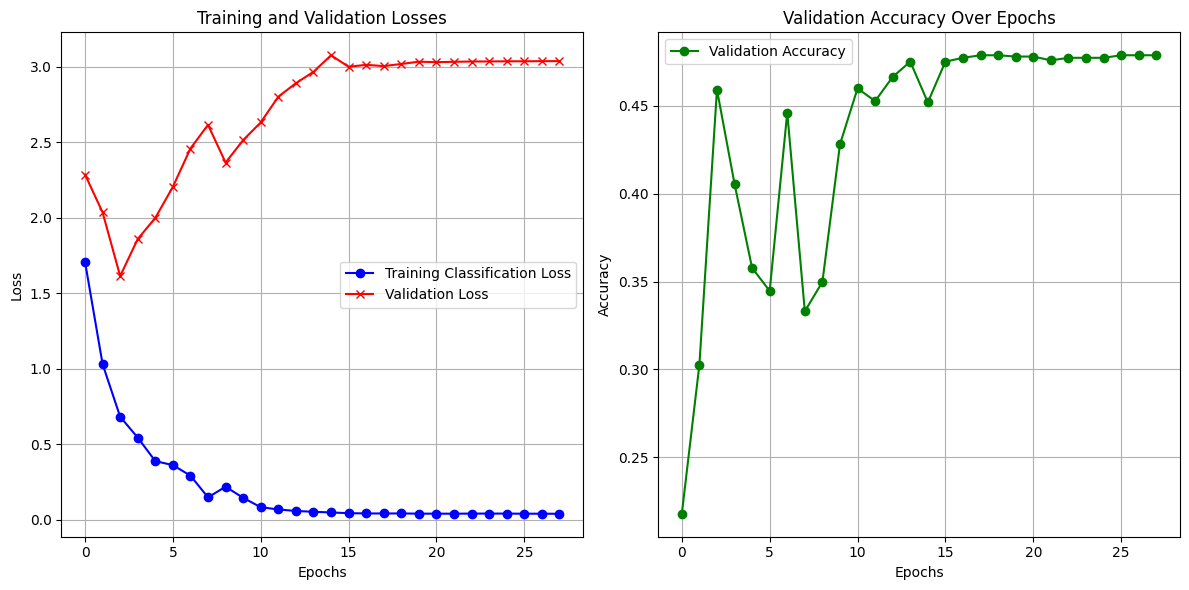

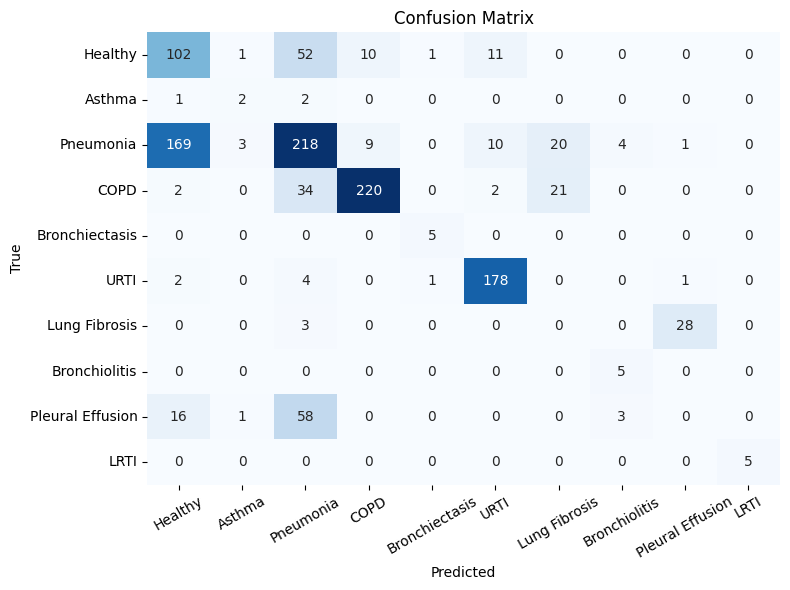

Accuracy: 0.61
Precision: 0.516
Recall: 0.6224
F1 Score: 0.5501

Test Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.35      0.58      0.43       177
          Asthma       0.29      0.40      0.33         5
       Pneumonia       0.59      0.50      0.54       434
            COPD       0.92      0.79      0.85       279
  Bronchiectasis       0.71      1.00      0.83         5
            URTI       0.89      0.96      0.92       186
   Lung Fibrosis       0.00      0.00      0.00        31
   Bronchiolitis       0.42      1.00      0.59         5
Pleural Effusion       0.00      0.00      0.00        78
            LRTI       1.00      1.00      1.00         5

        accuracy                           0.61      1205
       macro avg       0.52      0.62      0.55      1205
    weighted avg       0.62      0.61      0.61      1205



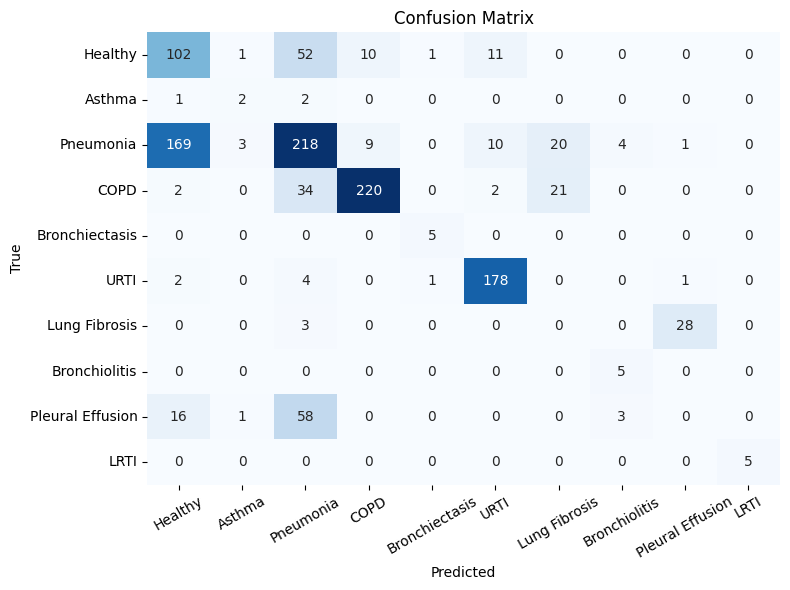

Test Accuracy for CustomCNN: 0.6099585062240664
F1 Score for CustomCNN: 0.5500802374921905


In [16]:

# Train and evaluate CustomCNN
print("\nTraining CustomCNN...")
custom_cnn_model = CustomCNN(num_classes=10).to(device)

# Define the optimizer with weight decay

optimizer = optim.SGD(custom_cnn_model.parameters(), lr=5e-3, weight_decay=1e-4, momentum=0.9)



# Use ReduceLROnPlateau scheduler instead of StepLR for patience-based learning rate adjustments
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.1)

# Use CrossEntropyLoss with class weights
criterion = nn.CrossEntropyLoss(weight=weights_tensor)

train_model(
    model=custom_cnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,  # Ensure your actual test_loader DataLoader is passed here
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    num_epochs=num_epochs,
    patience=patience,
    device=device,           # Make sure 'device' is also passed if you're using it
    class_names=class_names,
    lambda_coral=0.2        # You can explicitly set lambda_coral if desired
)

test_acc_customcnn,f1_customcnn = evaluate_model(custom_cnn_model, test_loader, device, class_names)
print(f"Test Accuracy for CustomCNN: {test_acc_customcnn}")
print(f"F1 Score for CustomCNN: {f1_customcnn}")

###ResNet50


Training ResNet50...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training on device: cuda
CORAL loss lambda: 1.4
Original feature dimension: 2048
CORAL projected feature dimension: 2048


Epoch 1/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 1 Training Metrics ---
Train Classification Loss: 1.7425, Train CORAL Loss: 0.6417, Train Accuracy: 0.2104, Train F1 Score: 0.1414

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.35      0.68      0.46      2299
          Asthma       0.00      0.00      0.00       342
       Pneumonia       0.00      0.00      0.00      3198
            COPD       0.00      0.00      0.00      1225
  Bronchiectasis       0.06      0.89      0.12       341
            URTI       0.53      0.20      0.29      1009
   Lung Fibrosis       0.00      0.00      0.00       620
   Bronchiolitis       0.00      0.00      0.00       261
Pleural Effusion       0.00      0.00      0.00       456
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.21      9782
       macro avg       0.09      0.18      0.09      9782
    weighted avg       0.14      0.21      0.14      9782



Epoch 1/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 1 Validation Metrics ---
Validation Loss: 2.0899, Validation Accuracy: 0.2317, Validation F1 Score: 0.1317

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.21      0.96      0.35       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.00      0.00      0.00       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.11      0.92      0.20        62
            URTI       0.91      0.73      0.81       135
   Lung Fibrosis       0.00      0.00      0.00        62
   Bronchiolitis       0.00      0.00      0.00         5
Pleural Effusion       0.00      0.00      0.00       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.23      1381
       macro avg       0.12      0.26      0.14      1381
    weighted avg       0.12      0.23      0.13      1381


Improvement detected in validat

Epoch 2/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 2 Training Metrics ---
Train Classification Loss: 1.0018, Train CORAL Loss: 0.0423, Train Accuracy: 0.4054, Train F1 Score: 0.2891

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.39      0.96      0.55      2299
          Asthma       0.00      0.00      0.00       342
       Pneumonia       0.57      0.02      0.04      3198
            COPD       0.48      0.18      0.26      1225
  Bronchiectasis       0.20      0.98      0.34       341
            URTI       0.74      0.94      0.83      1009
   Lung Fibrosis       0.00      0.00      0.00       620
   Bronchiolitis       0.00      0.00      0.00       261
Pleural Effusion       0.32      0.44      0.37       456
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.41      9782
       macro avg       0.27      0.35      0.24      9782
    weighted avg       0.44      0.41      0.29      9782



Epoch 2/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 2 Validation Metrics ---
Validation Loss: 2.1762, Validation Accuracy: 0.2679, Validation F1 Score: 0.2084

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.22      0.98      0.36       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.67      0.01      0.02       498
            COPD       0.03      0.04      0.03       123
  Bronchiectasis       0.15      0.56      0.24        62
            URTI       0.95      0.70      0.80       135
   Lung Fibrosis       0.00      0.00      0.00        62
   Bronchiolitis       0.00      0.00      0.00         5
Pleural Effusion       0.67      0.29      0.40       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.27      1381
       macro avg       0.27      0.26      0.19      1381
    weighted avg       0.47      0.27      0.21      1381


Improvement detected in validat

Epoch 3/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 3 Training Metrics ---
Train Classification Loss: 0.6960, Train CORAL Loss: 0.0372, Train Accuracy: 0.5282, Train F1 Score: 0.4555

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.49      0.94      0.64      2299
          Asthma       0.00      0.00      0.00       342
       Pneumonia       0.62      0.18      0.28      3198
            COPD       0.47      0.55      0.51      1225
  Bronchiectasis       0.44      0.99      0.61       341
            URTI       0.82      0.97      0.89      1009
   Lung Fibrosis       0.56      0.05      0.09       620
   Bronchiolitis       0.13      0.05      0.08       261
Pleural Effusion       0.45      0.83      0.58       456
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.53      9782
       macro avg       0.40      0.46      0.37      9782
    weighted avg       0.54      0.53      0.46      9782



Epoch 3/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 3 Validation Metrics ---
Validation Loss: 1.8729, Validation Accuracy: 0.3418, Validation F1 Score: 0.3105

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.23      0.86      0.37       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.66      0.07      0.13       498
            COPD       0.00      0.01      0.01       123
  Bronchiectasis       0.47      0.42      0.44        62
            URTI       0.88      0.79      0.83       135
   Lung Fibrosis       0.00      0.00      0.00        62
   Bronchiolitis       0.00      0.00      0.00         5
Pleural Effusion       0.78      0.72      0.75       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.34      1381
       macro avg       0.30      0.29      0.25      1381
    weighted avg       0.50      0.34      0.31      1381


Improvement detected in validat

Epoch 4/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 4 Training Metrics ---
Train Classification Loss: 0.5338, Train CORAL Loss: 0.0338, Train Accuracy: 0.6052, Train F1 Score: 0.5643

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.58      0.93      0.72      2299
          Asthma       0.00      0.00      0.00       342
       Pneumonia       0.70      0.29      0.41      3198
            COPD       0.52      0.64      0.57      1225
  Bronchiectasis       0.60      0.99      0.75       341
            URTI       0.87      0.97      0.91      1009
   Lung Fibrosis       0.55      0.33      0.41       620
   Bronchiolitis       0.26      0.54      0.35       261
Pleural Effusion       0.61      0.89      0.72       456
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.61      9782
       macro avg       0.47      0.56      0.48      9782
    weighted avg       0.61      0.61      0.56      9782



Epoch 4/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 4 Validation Metrics ---
Validation Loss: 1.6882, Validation Accuracy: 0.4077, Validation F1 Score: 0.4008

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.26      0.78      0.38       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.60      0.22      0.32       498
            COPD       0.02      0.03      0.03       123
  Bronchiectasis       0.55      0.39      0.45        62
            URTI       0.86      0.83      0.85       135
   Lung Fibrosis       0.14      0.11      0.12        62
   Bronchiolitis       0.02      0.20      0.03         5
Pleural Effusion       0.82      0.81      0.81       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.41      1381
       macro avg       0.33      0.34      0.30      1381
    weighted avg       0.49      0.41      0.40      1381


Improvement detected in validat

Epoch 5/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 5 Training Metrics ---
Train Classification Loss: 0.3968, Train CORAL Loss: 0.0354, Train Accuracy: 0.7065, Train F1 Score: 0.6825

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.70      0.95      0.81      2299
          Asthma       0.00      0.00      0.00       342
       Pneumonia       0.76      0.48      0.59      3198
            COPD       0.61      0.70      0.65      1225
  Bronchiectasis       0.78      1.00      0.87       341
            URTI       0.91      0.98      0.94      1009
   Lung Fibrosis       0.57      0.59      0.58       620
   Bronchiolitis       0.39      0.77      0.52       261
Pleural Effusion       0.77      0.92      0.84       456
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.71      9782
       macro avg       0.55      0.64      0.58      9782
    weighted avg       0.69      0.71      0.68      9782



Epoch 5/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 5 Validation Metrics ---
Validation Loss: 1.7312, Validation Accuracy: 0.4156, Validation F1 Score: 0.4203

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.28      0.74      0.41       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.63      0.38      0.47       498
            COPD       0.06      0.05      0.05       123
  Bronchiectasis       0.30      0.39      0.34        62
            URTI       0.83      0.79      0.81       135
   Lung Fibrosis       0.15      0.53      0.23        62
   Bronchiolitis       0.29      0.40      0.33         5
Pleural Effusion       0.97      0.41      0.58       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.42      1381
       macro avg       0.35      0.37      0.32      1381
    weighted avg       0.52      0.42      0.42      1381


Improvement detected in validat

Epoch 6/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 6 Training Metrics ---
Train Classification Loss: 0.3048, Train CORAL Loss: 0.0408, Train Accuracy: 0.7753, Train F1 Score: 0.7549

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.78      0.97      0.86      2299
          Asthma       0.00      0.00      0.00       342
       Pneumonia       0.78      0.62      0.69      3198
            COPD       0.73      0.81      0.77      1225
  Bronchiectasis       0.85      0.99      0.91       341
            URTI       0.92      0.98      0.95      1009
   Lung Fibrosis       0.61      0.64      0.63       620
   Bronchiolitis       0.55      0.90      0.68       261
Pleural Effusion       0.88      0.95      0.91       456
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.78      9782
       macro avg       0.61      0.69      0.64      9782
    weighted avg       0.75      0.78      0.75      9782



Epoch 6/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 6 Validation Metrics ---
Validation Loss: 2.0612, Validation Accuracy: 0.4482, Validation F1 Score: 0.4169

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.44      0.61      0.51       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.61      0.59      0.60       498
            COPD       0.03      0.01      0.01       123
  Bronchiectasis       0.14      0.56      0.23        62
            URTI       0.80      0.84      0.82       135
   Lung Fibrosis       0.31      0.81      0.44        62
   Bronchiolitis       0.06      0.80      0.12         5
Pleural Effusion       0.80      0.09      0.17       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.45      1381
       macro avg       0.32      0.43      0.29      1381
    weighted avg       0.50      0.45      0.42      1381


Improvement detected in validat

Epoch 7/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 7 Training Metrics ---
Train Classification Loss: 0.2204, Train CORAL Loss: 0.0320, Train Accuracy: 0.8376, Train F1 Score: 0.8200

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.85      0.97      0.91      2299
          Asthma       0.00      0.00      0.00       342
       Pneumonia       0.83      0.74      0.79      3198
            COPD       0.82      0.89      0.86      1225
  Bronchiectasis       0.87      0.99      0.93       341
            URTI       0.94      0.99      0.96      1009
   Lung Fibrosis       0.71      0.73      0.72       620
   Bronchiolitis       0.68      0.95      0.79       261
Pleural Effusion       0.90      0.97      0.93       456
            LRTI       1.00      0.39      0.56        31

        accuracy                           0.84      9782
       macro avg       0.76      0.76      0.74      9782
    weighted avg       0.81      0.84      0.82      9782



Epoch 7/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 7 Validation Metrics ---
Validation Loss: 1.8943, Validation Accuracy: 0.4185, Validation F1 Score: 0.3912

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.31      0.73      0.44       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.63      0.48      0.54       498
            COPD       0.15      0.05      0.07       123
  Bronchiectasis       0.23      0.23      0.23        62
            URTI       0.75      0.88      0.81       135
   Lung Fibrosis       0.16      0.73      0.26        62
   Bronchiolitis       0.24      1.00      0.38         5
Pleural Effusion       0.70      0.12      0.21       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.42      1381
       macro avg       0.32      0.42      0.29      1381
    weighted avg       0.48      0.42      0.39      1381


No improvement in validation ac

Epoch 8/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 8 Training Metrics ---
Train Classification Loss: 0.1474, Train CORAL Loss: 0.0323, Train Accuracy: 0.8975, Train F1 Score: 0.8809

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.89      0.98      0.94      2299
          Asthma       0.00      0.00      0.00       342
       Pneumonia       0.88      0.86      0.87      3198
            COPD       0.92      0.95      0.93      1225
  Bronchiectasis       0.97      1.00      0.99       341
            URTI       0.96      0.99      0.97      1009
   Lung Fibrosis       0.84      0.85      0.85       620
   Bronchiolitis       0.77      0.98      0.86       261
Pleural Effusion       0.97      0.99      0.98       456
            LRTI       1.00      0.55      0.71        31

        accuracy                           0.90      9782
       macro avg       0.82      0.82      0.81      9782
    weighted avg       0.87      0.90      0.88      9782



Epoch 8/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 8 Validation Metrics ---
Validation Loss: 1.8616, Validation Accuracy: 0.4613, Validation F1 Score: 0.4460

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.34      0.67      0.45       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.59      0.55      0.57       498
            COPD       0.09      0.02      0.04       123
  Bronchiectasis       0.30      0.15      0.20        62
            URTI       0.80      0.85      0.83       135
   Lung Fibrosis       0.17      0.71      0.28        62
   Bronchiolitis       0.56      1.00      0.71         5
Pleural Effusion       0.92      0.33      0.49       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.46      1381
       macro avg       0.38      0.43      0.36      1381
    weighted avg       0.51      0.46      0.45      1381


Improvement detected in validat

Epoch 9/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 9 Training Metrics ---
Train Classification Loss: 0.1112, Train CORAL Loss: 0.0280, Train Accuracy: 0.9208, Train F1 Score: 0.9044

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.92      0.99      0.95      2299
          Asthma       0.00      0.00      0.00       342
       Pneumonia       0.89      0.91      0.90      3198
            COPD       0.95      0.97      0.96      1225
  Bronchiectasis       0.97      1.00      0.99       341
            URTI       0.97      1.00      0.98      1009
   Lung Fibrosis       0.91      0.89      0.90       620
   Bronchiolitis       0.83      0.99      0.91       261
Pleural Effusion       0.98      0.99      0.98       456
            LRTI       1.00      0.90      0.95        31

        accuracy                           0.92      9782
       macro avg       0.84      0.86      0.85      9782
    weighted avg       0.89      0.92      0.90      9782



Epoch 9/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 9 Validation Metrics ---
Validation Loss: 1.7111, Validation Accuracy: 0.5025, Validation F1 Score: 0.4942

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.36      0.70      0.47       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.58      0.49      0.53       498
            COPD       0.04      0.02      0.02       123
  Bronchiectasis       0.57      0.13      0.21        62
            URTI       0.88      0.83      0.85       135
   Lung Fibrosis       0.17      0.52      0.26        62
   Bronchiolitis       0.08      1.00      0.15         5
Pleural Effusion       0.98      0.79      0.87       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.50      1381
       macro avg       0.37      0.45      0.34      1381
    weighted avg       0.53      0.50      0.49      1381


Improvement detected in validat

Epoch 10/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 10 Training Metrics ---
Train Classification Loss: 0.1054, Train CORAL Loss: 0.0231, Train Accuracy: 0.9220, Train F1 Score: 0.9055

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.92      0.99      0.95      2299
          Asthma       0.00      0.00      0.00       342
       Pneumonia       0.89      0.91      0.90      3198
            COPD       0.95      0.97      0.96      1225
  Bronchiectasis       0.93      1.00      0.96       341
            URTI       0.98      1.00      0.99      1009
   Lung Fibrosis       0.93      0.91      0.92       620
   Bronchiolitis       0.88      1.00      0.94       261
Pleural Effusion       0.96      0.99      0.97       456
            LRTI       0.94      0.94      0.94        31

        accuracy                           0.92      9782
       macro avg       0.84      0.87      0.85      9782
    weighted avg       0.89      0.92      0.91      9782



Epoch 10/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 10 Validation Metrics ---
Validation Loss: 2.1210, Validation Accuracy: 0.4989, Validation F1 Score: 0.4777

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.57      0.60      0.58       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.57      0.71      0.63       498
            COPD       0.15      0.06      0.08       123
  Bronchiectasis       0.33      0.11      0.17        62
            URTI       0.88      0.80      0.84       135
   Lung Fibrosis       0.17      0.71      0.27        62
   Bronchiolitis       0.50      1.00      0.67         5
Pleural Effusion       0.95      0.27      0.42       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.50      1381
       macro avg       0.41      0.43      0.37      1381
    weighted avg       0.55      0.50      0.48      1381


No improvement in validation a

Epoch 11/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 11 Training Metrics ---
Train Classification Loss: 0.0557, Train CORAL Loss: 0.0090, Train Accuracy: 0.9493, Train F1 Score: 0.9326

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.94      1.00      0.97      2299
          Asthma       0.00      0.00      0.00       342
       Pneumonia       0.92      0.96      0.94      3198
            COPD       0.99      0.99      0.99      1225
  Bronchiectasis       0.99      1.00      1.00       341
            URTI       0.99      1.00      0.99      1009
   Lung Fibrosis       0.98      0.99      0.98       620
   Bronchiolitis       0.89      1.00      0.94       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       0.97      1.00      0.98        31

        accuracy                           0.95      9782
       macro avg       0.87      0.89      0.88      9782
    weighted avg       0.92      0.95      0.93      9782



Epoch 11/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 11 Validation Metrics ---
Validation Loss: 1.8522, Validation Accuracy: 0.5525, Validation F1 Score: 0.5214

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.46      0.65      0.54       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.54      0.73      0.62       498
            COPD       0.14      0.05      0.07       123
  Bronchiectasis       0.54      0.11      0.19        62
            URTI       0.89      0.81      0.85       135
   Lung Fibrosis       0.11      0.19      0.14        62
   Bronchiolitis       0.36      1.00      0.53         5
Pleural Effusion       0.94      0.70      0.80       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.55      1381
       macro avg       0.40      0.42      0.37      1381
    weighted avg       0.53      0.55      0.52      1381


Improvement detected in valida

Epoch 12/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 12 Training Metrics ---
Train Classification Loss: 0.0472, Train CORAL Loss: 0.0084, Train Accuracy: 0.9539, Train F1 Score: 0.9371

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.94      1.00      0.97      2299
          Asthma       0.00      0.00      0.00       342
       Pneumonia       0.92      0.97      0.95      3198
            COPD       0.99      1.00      0.99      1225
  Bronchiectasis       1.00      1.00      1.00       341
            URTI       0.99      1.00      0.99      1009
   Lung Fibrosis       0.99      0.99      0.99       620
   Bronchiolitis       0.91      1.00      0.95       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       0.97      1.00      0.98        31

        accuracy                           0.95      9782
       macro avg       0.87      0.90      0.88      9782
    weighted avg       0.92      0.95      0.94      9782



Epoch 12/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 12 Validation Metrics ---
Validation Loss: 1.9420, Validation Accuracy: 0.5547, Validation F1 Score: 0.5185

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.53      0.61      0.57       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.55      0.77      0.64       498
            COPD       0.10      0.01      0.02       123
  Bronchiectasis       0.47      0.13      0.20        62
            URTI       0.84      0.85      0.85       135
   Lung Fibrosis       0.19      0.44      0.26        62
   Bronchiolitis       0.33      1.00      0.50         5
Pleural Effusion       0.91      0.57      0.70       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.55      1381
       macro avg       0.39      0.44      0.37      1381
    weighted avg       0.53      0.55      0.52      1381


Improvement detected in valida

Epoch 13/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 13 Training Metrics ---
Train Classification Loss: 0.0418, Train CORAL Loss: 0.0084, Train Accuracy: 0.9559, Train F1 Score: 0.9395

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.95      1.00      0.97      2299
          Asthma       1.00      0.01      0.01       342
       Pneumonia       0.92      0.98      0.95      3198
            COPD       1.00      1.00      1.00      1225
  Bronchiectasis       1.00      1.00      1.00       341
            URTI       0.99      1.00      1.00      1009
   Lung Fibrosis       1.00      0.99      0.99       620
   Bronchiolitis       0.90      1.00      0.95       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       0.97      1.00      0.98        31

        accuracy                           0.96      9782
       macro avg       0.97      0.90      0.89      9782
    weighted avg       0.96      0.96      0.94      9782



Epoch 13/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 13 Validation Metrics ---
Validation Loss: 2.1243, Validation Accuracy: 0.5033, Validation F1 Score: 0.4687

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.37      0.70      0.48       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.51      0.65      0.58       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.41      0.27      0.33        62
            URTI       0.81      0.85      0.83       135
   Lung Fibrosis       0.16      0.21      0.18        62
   Bronchiolitis       0.18      1.00      0.30         5
Pleural Effusion       0.91      0.46      0.61       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.50      1381
       macro avg       0.34      0.41      0.33      1381
    weighted avg       0.48      0.50      0.47      1381


No improvement in validation a

Epoch 14/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 14 Training Metrics ---
Train Classification Loss: 0.0398, Train CORAL Loss: 0.0082, Train Accuracy: 0.9582, Train F1 Score: 0.9433

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.96      1.00      0.98      2299
          Asthma       1.00      0.04      0.07       342
       Pneumonia       0.92      0.98      0.95      3198
            COPD       1.00      1.00      1.00      1225
  Bronchiectasis       1.00      1.00      1.00       341
            URTI       0.99      1.00      1.00      1009
   Lung Fibrosis       1.00      0.99      0.99       620
   Bronchiolitis       0.89      1.00      0.94       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       0.97      1.00      0.98        31

        accuracy                           0.96      9782
       macro avg       0.97      0.90      0.89      9782
    weighted avg       0.96      0.96      0.94      9782



Epoch 14/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 14 Validation Metrics ---
Validation Loss: 1.9029, Validation Accuracy: 0.5728, Validation F1 Score: 0.5436

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.59      0.58      0.59       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.56      0.75      0.64       498
            COPD       0.10      0.02      0.04       123
  Bronchiectasis       0.61      0.18      0.28        62
            URTI       0.87      0.84      0.85       135
   Lung Fibrosis       0.21      0.58      0.31        62
   Bronchiolitis       0.42      1.00      0.59         5
Pleural Effusion       0.94      0.69      0.79       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.57      1381
       macro avg       0.43      0.46      0.41      1381
    weighted avg       0.55      0.57      0.54      1381


Improvement detected in valida

Epoch 15/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 15 Training Metrics ---
Train Classification Loss: 0.0362, Train CORAL Loss: 0.0079, Train Accuracy: 0.9603, Train F1 Score: 0.9475

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.95      1.00      0.97      2299
          Asthma       1.00      0.08      0.16       342
       Pneumonia       0.93      0.98      0.96      3198
            COPD       1.00      1.00      1.00      1225
  Bronchiectasis       1.00      1.00      1.00       341
            URTI       0.99      1.00      1.00      1009
   Lung Fibrosis       1.00      1.00      1.00       620
   Bronchiolitis       0.88      1.00      0.94       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       1.00      1.00      1.00        31

        accuracy                           0.96      9782
       macro avg       0.97      0.91      0.90      9782
    weighted avg       0.96      0.96      0.95      9782



Epoch 15/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 15 Validation Metrics ---
Validation Loss: 2.0080, Validation Accuracy: 0.5127, Validation F1 Score: 0.4907

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.41      0.68      0.51       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.56      0.65      0.60       498
            COPD       0.15      0.05      0.07       123
  Bronchiectasis       0.58      0.18      0.27        62
            URTI       0.83      0.85      0.84       135
   Lung Fibrosis       0.21      0.56      0.31        62
   Bronchiolitis       0.71      1.00      0.83         5
Pleural Effusion       0.93      0.44      0.59       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.51      1381
       macro avg       0.44      0.44      0.40      1381
    weighted avg       0.53      0.51      0.49      1381


No improvement in validation a

Epoch 16/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 16 Training Metrics ---
Train Classification Loss: 0.0327, Train CORAL Loss: 0.0075, Train Accuracy: 0.9628, Train F1 Score: 0.9513

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.95      1.00      0.97      2299
          Asthma       1.00      0.12      0.21       342
       Pneumonia       0.94      0.98      0.96      3198
            COPD       1.00      1.00      1.00      1225
  Bronchiectasis       1.00      1.00      1.00       341
            URTI       1.00      1.00      1.00      1009
   Lung Fibrosis       1.00      1.00      1.00       620
   Bronchiolitis       0.88      1.00      0.94       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       1.00      1.00      1.00        31

        accuracy                           0.96      9782
       macro avg       0.98      0.91      0.91      9782
    weighted avg       0.96      0.96      0.95      9782



Epoch 16/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 16 Validation Metrics ---
Validation Loss: 2.0400, Validation Accuracy: 0.5301, Validation F1 Score: 0.4958

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.46      0.69      0.55       171
          Asthma       1.00      0.01      0.03        78
       Pneumonia       0.54      0.71      0.61       498
            COPD       0.19      0.03      0.06       123
  Bronchiectasis       0.38      0.24      0.30        62
            URTI       0.82      0.83      0.83       135
   Lung Fibrosis       0.26      0.60      0.36        62
   Bronchiolitis       0.50      1.00      0.67         5
Pleural Effusion       0.94      0.40      0.56       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.53      1381
       macro avg       0.51      0.45      0.40      1381
    weighted avg       0.58      0.53      0.50      1381


No improvement in validation a

Epoch 17/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 17 Training Metrics ---
Train Classification Loss: 0.0307, Train CORAL Loss: 0.0065, Train Accuracy: 0.9651, Train F1 Score: 0.9559

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.96      1.00      0.98      2299
          Asthma       1.00      0.19      0.32       342
       Pneumonia       0.94      0.98      0.96      3198
            COPD       1.00      1.00      1.00      1225
  Bronchiectasis       1.00      1.00      1.00       341
            URTI       1.00      1.00      1.00      1009
   Lung Fibrosis       1.00      1.00      1.00       620
   Bronchiolitis       0.88      1.00      0.94       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       1.00      1.00      1.00        31

        accuracy                           0.97      9782
       macro avg       0.98      0.92      0.92      9782
    weighted avg       0.97      0.97      0.96      9782



Epoch 17/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 17 Validation Metrics ---
Validation Loss: 2.1314, Validation Accuracy: 0.5098, Validation F1 Score: 0.4791

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.39      0.72      0.50       171
          Asthma       0.25      0.01      0.02        78
       Pneumonia       0.52      0.66      0.59       498
            COPD       0.16      0.02      0.04       123
  Bronchiectasis       0.40      0.27      0.32        62
            URTI       0.82      0.82      0.82       135
   Lung Fibrosis       0.20      0.34      0.25        62
   Bronchiolitis       0.45      1.00      0.62         5
Pleural Effusion       0.94      0.43      0.59       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.51      1381
       macro avg       0.41      0.43      0.38      1381
    weighted avg       0.52      0.51      0.48      1381


No improvement in validation a

Epoch 18/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 18 Training Metrics ---
Train Classification Loss: 0.0298, Train CORAL Loss: 0.0064, Train Accuracy: 0.9647, Train F1 Score: 0.9558

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.95      1.00      0.97      2299
          Asthma       1.00      0.20      0.33       342
       Pneumonia       0.94      0.98      0.96      3198
            COPD       1.00      1.00      1.00      1225
  Bronchiectasis       1.00      1.00      1.00       341
            URTI       1.00      1.00      1.00      1009
   Lung Fibrosis       1.00      1.00      1.00       620
   Bronchiolitis       0.88      1.00      0.94       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       1.00      1.00      1.00        31

        accuracy                           0.96      9782
       macro avg       0.98      0.92      0.92      9782
    weighted avg       0.97      0.96      0.96      9782



Epoch 18/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 18 Validation Metrics ---
Validation Loss: 2.0505, Validation Accuracy: 0.5373, Validation F1 Score: 0.5097

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.43      0.66      0.52       171
          Asthma       0.20      0.03      0.05        78
       Pneumonia       0.53      0.69      0.60       498
            COPD       0.13      0.02      0.04       123
  Bronchiectasis       0.70      0.23      0.34        62
            URTI       0.85      0.81      0.83       135
   Lung Fibrosis       0.16      0.26      0.20        62
   Bronchiolitis       0.19      1.00      0.32         5
Pleural Effusion       0.91      0.62      0.74       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.54      1381
       macro avg       0.41      0.43      0.36      1381
    weighted avg       0.53      0.54      0.51      1381


No improvement in validation a

Epoch 19/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 19 Training Metrics ---
Train Classification Loss: 0.0306, Train CORAL Loss: 0.0065, Train Accuracy: 0.9673, Train F1 Score: 0.9598

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.96      1.00      0.98      2299
          Asthma       1.00      0.25      0.39       342
       Pneumonia       0.95      0.98      0.97      3198
            COPD       1.00      1.00      1.00      1225
  Bronchiectasis       1.00      1.00      1.00       341
            URTI       1.00      1.00      1.00      1009
   Lung Fibrosis       1.00      1.00      1.00       620
   Bronchiolitis       0.88      1.00      0.94       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       1.00      1.00      1.00        31

        accuracy                           0.97      9782
       macro avg       0.98      0.92      0.93      9782
    weighted avg       0.97      0.97      0.96      9782



Epoch 19/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 19 Validation Metrics ---
Validation Loss: 2.1309, Validation Accuracy: 0.4967, Validation F1 Score: 0.4787

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.33      0.71      0.45       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.52      0.61      0.56       498
            COPD       0.17      0.07      0.09       123
  Bronchiectasis       0.50      0.21      0.30        62
            URTI       0.92      0.80      0.85       135
   Lung Fibrosis       0.15      0.23      0.18        62
   Bronchiolitis       0.42      1.00      0.59         5
Pleural Effusion       0.95      0.51      0.67       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.50      1381
       macro avg       0.39      0.41      0.37      1381
    weighted avg       0.51      0.50      0.48      1381


No improvement in validation a

Epoch 20/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 20 Training Metrics ---
Train Classification Loss: 0.0300, Train CORAL Loss: 0.0064, Train Accuracy: 0.9663, Train F1 Score: 0.9580

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.95      1.00      0.98      2299
          Asthma       0.99      0.22      0.35       342
       Pneumonia       0.95      0.98      0.96      3198
            COPD       1.00      1.00      1.00      1225
  Bronchiectasis       1.00      1.00      1.00       341
            URTI       1.00      1.00      1.00      1009
   Lung Fibrosis       1.00      1.00      1.00       620
   Bronchiolitis       0.87      1.00      0.93       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       1.00      1.00      1.00        31

        accuracy                           0.97      9782
       macro avg       0.98      0.92      0.92      9782
    weighted avg       0.97      0.97      0.96      9782



Epoch 20/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 20 Validation Metrics ---
Validation Loss: 2.4135, Validation Accuracy: 0.4728, Validation F1 Score: 0.4408

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.34      0.74      0.47       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.47      0.64      0.54       498
            COPD       0.14      0.03      0.05       123
  Bronchiectasis       0.76      0.21      0.33        62
            URTI       0.94      0.76      0.84       135
   Lung Fibrosis       0.03      0.02      0.02        62
   Bronchiolitis       0.10      1.00      0.18         5
Pleural Effusion       0.94      0.37      0.53       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.47      1381
       macro avg       0.37      0.38      0.30      1381
    weighted avg       0.50      0.47      0.44      1381


No improvement in validation a

Epoch 21/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 21 Training Metrics ---
Train Classification Loss: 0.0292, Train CORAL Loss: 0.0063, Train Accuracy: 0.9676, Train F1 Score: 0.9605

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.96      1.00      0.98      2299
          Asthma       1.00      0.26      0.41       342
       Pneumonia       0.95      0.98      0.97      3198
            COPD       1.00      1.00      1.00      1225
  Bronchiectasis       1.00      1.00      1.00       341
            URTI       1.00      1.00      1.00      1009
   Lung Fibrosis       1.00      1.00      1.00       620
   Bronchiolitis       0.86      1.00      0.92       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       1.00      1.00      1.00        31

        accuracy                           0.97      9782
       macro avg       0.98      0.92      0.93      9782
    weighted avg       0.97      0.97      0.96      9782



Epoch 21/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 21 Validation Metrics ---
Validation Loss: 2.2891, Validation Accuracy: 0.4750, Validation F1 Score: 0.4660

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.30      0.70      0.42       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.50      0.55      0.52       498
            COPD       0.12      0.08      0.10       123
  Bronchiectasis       0.65      0.24      0.35        62
            URTI       0.96      0.70      0.81       135
   Lung Fibrosis       0.07      0.06      0.07        62
   Bronchiolitis       0.16      1.00      0.27         5
Pleural Effusion       0.96      0.61      0.75       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.48      1381
       macro avg       0.37      0.40      0.33      1381
    weighted avg       0.50      0.48      0.47      1381


No improvement in validation a

Epoch 22/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 22 Training Metrics ---
Train Classification Loss: 0.0282, Train CORAL Loss: 0.0064, Train Accuracy: 0.9679, Train F1 Score: 0.9599

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.96      1.00      0.98      2299
          Asthma       1.00      0.23      0.38       342
       Pneumonia       0.95      0.99      0.97      3198
            COPD       1.00      1.00      1.00      1225
  Bronchiectasis       1.00      1.00      1.00       341
            URTI       1.00      1.00      1.00      1009
   Lung Fibrosis       1.00      1.00      1.00       620
   Bronchiolitis       0.90      1.00      0.95       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       1.00      1.00      1.00        31

        accuracy                           0.97      9782
       macro avg       0.98      0.92      0.93      9782
    weighted avg       0.97      0.97      0.96      9782



Epoch 22/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 22 Validation Metrics ---
Validation Loss: 2.2698, Validation Accuracy: 0.4794, Validation F1 Score: 0.4556

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.33      0.73      0.46       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.48      0.60      0.54       498
            COPD       0.22      0.03      0.06       123
  Bronchiectasis       0.61      0.23      0.33        62
            URTI       0.93      0.78      0.85       135
   Lung Fibrosis       0.02      0.02      0.02        62
   Bronchiolitis       0.08      1.00      0.16         5
Pleural Effusion       0.92      0.50      0.65       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.48      1381
       macro avg       0.36      0.39      0.31      1381
    weighted avg       0.50      0.48      0.46      1381


No improvement in validation a

Epoch 23/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 23 Training Metrics ---
Train Classification Loss: 0.0282, Train CORAL Loss: 0.0063, Train Accuracy: 0.9674, Train F1 Score: 0.9600

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.96      1.00      0.98      2299
          Asthma       1.00      0.25      0.40       342
       Pneumonia       0.95      0.98      0.97      3198
            COPD       1.00      1.00      1.00      1225
  Bronchiectasis       1.00      1.00      1.00       341
            URTI       1.00      1.00      1.00      1009
   Lung Fibrosis       1.00      1.00      1.00       620
   Bronchiolitis       0.86      1.00      0.92       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       1.00      1.00      1.00        31

        accuracy                           0.97      9782
       macro avg       0.98      0.92      0.93      9782
    weighted avg       0.97      0.97      0.96      9782



Epoch 23/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 23 Validation Metrics ---
Validation Loss: 2.3541, Validation Accuracy: 0.4533, Validation F1 Score: 0.4275

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.30      0.76      0.43       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.48      0.56      0.52       498
            COPD       0.11      0.02      0.04       123
  Bronchiectasis       0.74      0.23      0.35        62
            URTI       0.89      0.80      0.84       135
   Lung Fibrosis       0.10      0.10      0.10        62
   Bronchiolitis       0.17      1.00      0.29         5
Pleural Effusion       0.91      0.37      0.52       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.45      1381
       macro avg       0.37      0.38      0.31      1381
    weighted avg       0.49      0.45      0.43      1381


No improvement in validation a

Epoch 24/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 24 Training Metrics ---
Train Classification Loss: 0.0268, Train CORAL Loss: 0.0062, Train Accuracy: 0.9690, Train F1 Score: 0.9624

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.96      1.00      0.98      2299
          Asthma       1.00      0.28      0.44       342
       Pneumonia       0.95      0.98      0.97      3198
            COPD       1.00      1.00      1.00      1225
  Bronchiectasis       1.00      1.00      1.00       341
            URTI       1.00      1.00      1.00      1009
   Lung Fibrosis       1.00      1.00      1.00       620
   Bronchiolitis       0.86      1.00      0.92       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       1.00      1.00      1.00        31

        accuracy                           0.97      9782
       macro avg       0.98      0.93      0.93      9782
    weighted avg       0.97      0.97      0.96      9782



Epoch 24/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 24 Validation Metrics ---
Validation Loss: 2.2833, Validation Accuracy: 0.4432, Validation F1 Score: 0.4247

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.28      0.80      0.42       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.52      0.47      0.49       498
            COPD       0.11      0.02      0.04       123
  Bronchiectasis       0.37      0.24      0.29        62
            URTI       0.84      0.83      0.84       135
   Lung Fibrosis       0.21      0.47      0.29        62
   Bronchiolitis       0.71      1.00      0.83         5
Pleural Effusion       0.95      0.35      0.51       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.44      1381
       macro avg       0.40      0.42      0.37      1381
    weighted avg       0.49      0.44      0.42      1381


No improvement in validation a

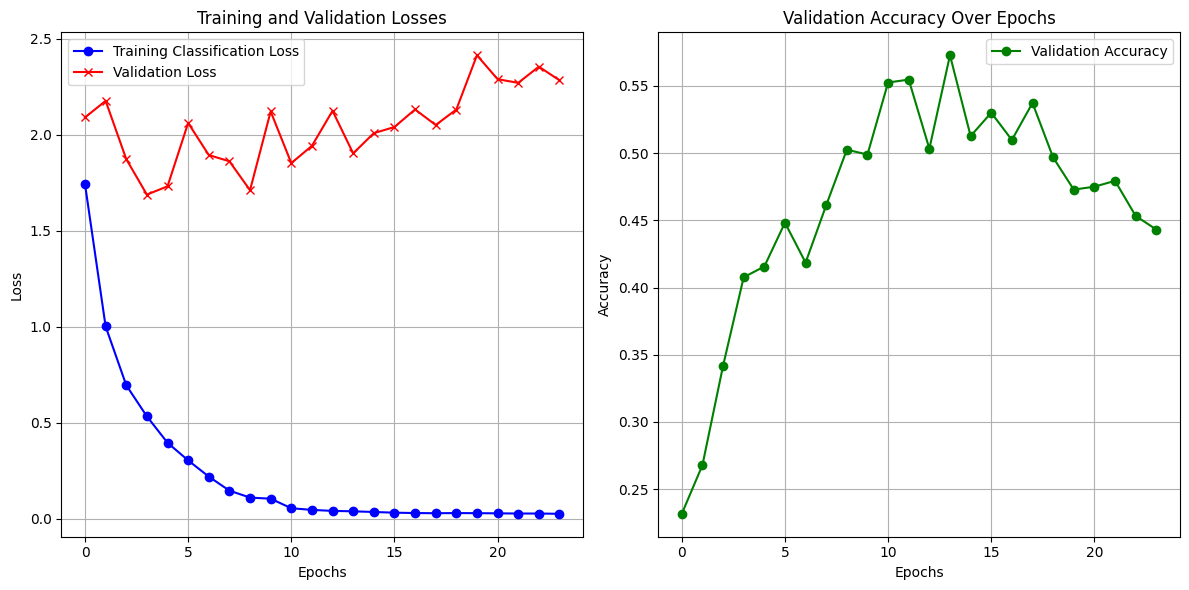

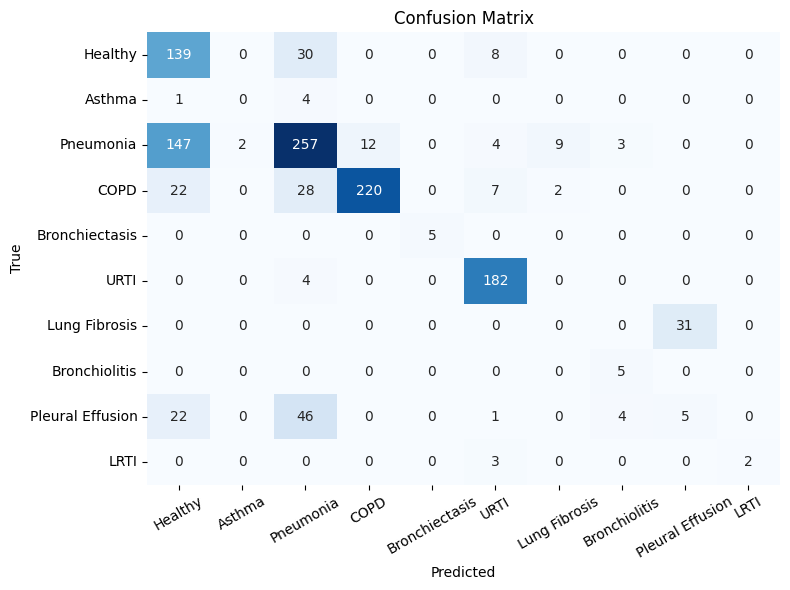

Accuracy: 0.6763
Precision: 0.5508
Recall: 0.5609
F1 Score: 0.5227

Test Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.42      0.79      0.55       177
          Asthma       0.00      0.00      0.00         5
       Pneumonia       0.70      0.59      0.64       434
            COPD       0.95      0.79      0.86       279
  Bronchiectasis       1.00      1.00      1.00         5
            URTI       0.89      0.98      0.93       186
   Lung Fibrosis       0.00      0.00      0.00        31
   Bronchiolitis       0.42      1.00      0.59         5
Pleural Effusion       0.14      0.06      0.09        78
            LRTI       1.00      0.40      0.57         5

        accuracy                           0.68      1205
       macro avg       0.55      0.56      0.52      1205
    weighted avg       0.69      0.68      0.67      1205



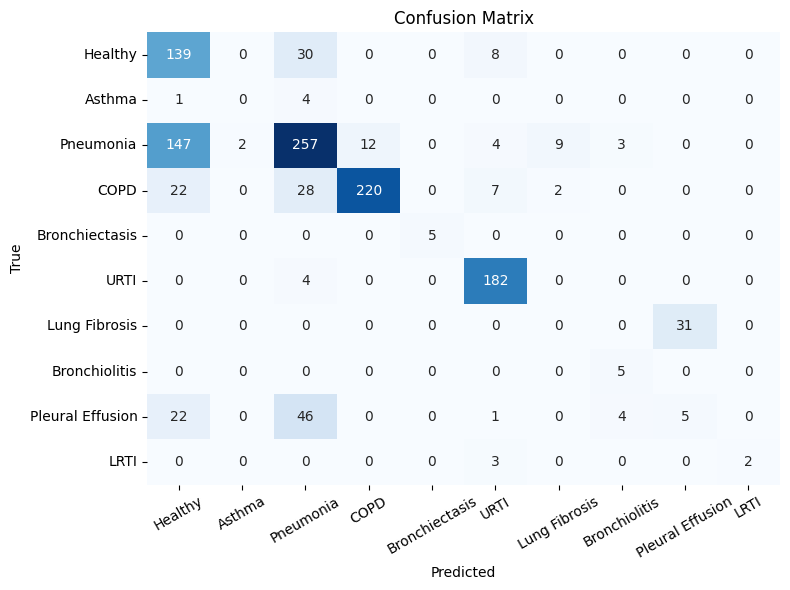

Test Accuracy for ResNet50: 0.6763485477178424
F1 Score for ResNet50: 0.5226729927708831


In [25]:

# Train and evaluate ResNet50
print("\nTraining ResNet50...")
model_resnet50 = ResNet50_Features(num_classes=10).to(device)
optimizer_resnet50 = optim.AdamW(model_resnet50.parameters(), lr=5e-5, weight_decay=1e-5)
scheduler_resnet50 = ReduceLROnPlateau(optimizer_resnet50, mode='min', patience=5, factor=0.1)
criterion_resnet50 = nn.CrossEntropyLoss(weight=weights_tensor)

train_model(
    model=model_resnet50,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,  # Ensure your actual test_loader DataLoader is passed here
    criterion=criterion_resnet50,
    optimizer=optimizer_resnet50,
    scheduler=scheduler_resnet50,
    num_epochs=num_epochs,
    patience=patience,
    device=device,           # Make sure 'device' is also passed if you're using it
    class_names=class_names,
    lambda_coral=1.4       # You can explicitly set lambda_coral if desired
)
test_acc_resnet50,f1_resnet50 = evaluate_model(model_resnet50, test_loader,device, class_names)
print(f"Test Accuracy for ResNet50: {test_acc_resnet50}")
print(f"F1 Score for ResNet50: {f1_resnet50}")

###DenseNet16


Training DenseNet121...


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Starting training on device: cuda
CORAL loss lambda: 1.4
Original feature dimension: 1024
CORAL projected feature dimension: 2048


Epoch 1/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 1 Training Metrics ---
Train Classification Loss: 1.8855, Train CORAL Loss: 3.2514, Train Accuracy: 0.1910, Train F1 Score: 0.1198

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.33      0.65      0.43      2299
          Asthma       0.00      0.00      0.00       342
       Pneumonia       0.30      0.02      0.03      3198
            COPD       0.08      0.00      0.00      1225
  Bronchiectasis       0.06      0.88      0.12       341
            URTI       0.13      0.01      0.02      1009
   Lung Fibrosis       0.00      0.00      0.00       620
   Bronchiolitis       0.00      0.00      0.00       261
Pleural Effusion       0.00      0.00      0.00       456
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.19      9782
       macro avg       0.09      0.16      0.06      9782
    weighted avg       0.20      0.19      0.12      9782



Epoch 1/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 1 Validation Metrics ---
Validation Loss: 2.3214, Validation Accuracy: 0.1325, Validation F1 Score: 0.0435

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.19      0.78      0.30       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.00      0.00      0.00       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.07      0.79      0.13        62
            URTI       0.00      0.00      0.00       135
   Lung Fibrosis       0.00      0.00      0.00        62
   Bronchiolitis       0.00      0.00      0.00         5
Pleural Effusion       0.00      0.00      0.00       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.13      1381
       macro avg       0.03      0.16      0.04      1381
    weighted avg       0.03      0.13      0.04      1381


Improvement detected in validat

Epoch 2/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 2 Training Metrics ---
Train Classification Loss: 1.7317, Train CORAL Loss: 0.0670, Train Accuracy: 0.2118, Train F1 Score: 0.1158

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.34      0.76      0.47      2299
          Asthma       0.00      0.00      0.00       342
       Pneumonia       0.00      0.00      0.00      3198
            COPD       0.00      0.00      0.00      1225
  Bronchiectasis       0.07      0.96      0.13       341
            URTI       0.00      0.00      0.00      1009
   Lung Fibrosis       0.00      0.00      0.00       620
   Bronchiolitis       0.00      0.00      0.00       261
Pleural Effusion       0.00      0.00      0.00       456
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.21      9782
       macro avg       0.04      0.17      0.06      9782
    weighted avg       0.08      0.21      0.12      9782



Epoch 2/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 2 Validation Metrics ---
Validation Loss: 2.1910, Validation Accuracy: 0.1347, Validation F1 Score: 0.0443

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.19      0.80      0.31       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.00      0.00      0.00       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.07      0.81      0.14        62
            URTI       0.00      0.00      0.00       135
   Lung Fibrosis       0.00      0.00      0.00        62
   Bronchiolitis       0.00      0.00      0.00         5
Pleural Effusion       0.00      0.00      0.00       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.13      1381
       macro avg       0.03      0.16      0.04      1381
    weighted avg       0.03      0.13      0.04      1381


Improvement detected in validat

Epoch 3/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 3 Training Metrics ---
Train Classification Loss: 1.5430, Train CORAL Loss: 0.0391, Train Accuracy: 0.2543, Train F1 Score: 0.1363

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.35      0.91      0.51      2299
          Asthma       0.00      0.00      0.00       342
       Pneumonia       0.00      0.00      0.00      3198
            COPD       0.00      0.00      0.00      1225
  Bronchiectasis       0.09      0.98      0.16       341
            URTI       0.89      0.05      0.10      1009
   Lung Fibrosis       0.00      0.00      0.00       620
   Bronchiolitis       0.00      0.00      0.00       261
Pleural Effusion       0.00      0.00      0.00       456
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.25      9782
       macro avg       0.13      0.19      0.08      9782
    weighted avg       0.18      0.25      0.14      9782



Epoch 3/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 3 Validation Metrics ---
Validation Loss: 2.0522, Validation Accuracy: 0.1760, Validation F1 Score: 0.0785

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.19      0.92      0.32       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.00      0.00      0.00       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.11      0.97      0.20        62
            URTI       0.89      0.19      0.31       135
   Lung Fibrosis       0.00      0.00      0.00        62
   Bronchiolitis       0.00      0.00      0.00         5
Pleural Effusion       0.00      0.00      0.00       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.18      1381
       macro avg       0.12      0.21      0.08      1381
    weighted avg       0.12      0.18      0.08      1381


Improvement detected in validat

Epoch 4/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 4 Training Metrics ---
Train Classification Loss: 1.3777, Train CORAL Loss: 0.0286, Train Accuracy: 0.3275, Train F1 Score: 0.2051

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.38      0.91      0.53      2299
          Asthma       0.00      0.00      0.00       342
       Pneumonia       0.00      0.00      0.00      3198
            COPD       0.00      0.00      0.00      1225
  Bronchiectasis       0.11      0.99      0.20       341
            URTI       0.64      0.77      0.70      1009
   Lung Fibrosis       0.00      0.00      0.00       620
   Bronchiolitis       0.00      0.00      0.00       261
Pleural Effusion       0.00      0.00      0.00       456
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.33      9782
       macro avg       0.11      0.27      0.14      9782
    weighted avg       0.16      0.33      0.21      9782



Epoch 4/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 4 Validation Metrics ---
Validation Loss: 1.9691, Validation Accuracy: 0.2448, Validation F1 Score: 0.1316

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.20      0.87      0.33       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.00      0.00      0.00       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.13      0.97      0.22        62
            URTI       0.72      0.96      0.82       135
   Lung Fibrosis       0.00      0.00      0.00        62
   Bronchiolitis       0.00      0.00      0.00         5
Pleural Effusion       0.00      0.00      0.00       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.24      1381
       macro avg       0.11      0.28      0.14      1381
    weighted avg       0.10      0.24      0.13      1381


Improvement detected in validat

Epoch 5/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 5 Training Metrics ---
Train Classification Loss: 1.2005, Train CORAL Loss: 0.0264, Train Accuracy: 0.3544, Train F1 Score: 0.2187

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.39      0.94      0.55      2299
          Asthma       0.00      0.00      0.00       342
       Pneumonia       0.50      0.00      0.00      3198
            COPD       1.00      0.00      0.00      1225
  Bronchiectasis       0.12      0.99      0.22       341
            URTI       0.67      0.95      0.79      1009
   Lung Fibrosis       0.00      0.00      0.00       620
   Bronchiolitis       0.00      0.00      0.00       261
Pleural Effusion       0.00      0.00      0.00       456
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.35      9782
       macro avg       0.27      0.29      0.16      9782
    weighted avg       0.45      0.35      0.22      9782



Epoch 5/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 5 Validation Metrics ---
Validation Loss: 1.9500, Validation Accuracy: 0.2542, Validation F1 Score: 0.1404

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.22      0.98      0.36       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.00      0.00      0.00       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.13      1.00      0.23        62
            URTI       0.85      0.90      0.88       135
   Lung Fibrosis       0.00      0.00      0.00        62
   Bronchiolitis       0.00      0.00      0.00         5
Pleural Effusion       0.00      0.00      0.00       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.25      1381
       macro avg       0.12      0.29      0.15      1381
    weighted avg       0.12      0.25      0.14      1381


Improvement detected in validat

Epoch 6/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 6 Training Metrics ---
Train Classification Loss: 0.9986, Train CORAL Loss: 0.0267, Train Accuracy: 0.3790, Train F1 Score: 0.2495

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.38      0.97      0.55      2299
          Asthma       0.00      0.00      0.00       342
       Pneumonia       0.31      0.00      0.01      3198
            COPD       0.56      0.04      0.07      1225
  Bronchiectasis       0.17      0.99      0.29       341
            URTI       0.79      0.97      0.87      1009
   Lung Fibrosis       0.00      0.00      0.00       620
   Bronchiolitis       0.00      0.00      0.00       261
Pleural Effusion       0.19      0.25      0.22       456
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.38      9782
       macro avg       0.24      0.32      0.20      9782
    weighted avg       0.36      0.38      0.25      9782



Epoch 6/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 6 Validation Metrics ---
Validation Loss: 2.2721, Validation Accuracy: 0.2520, Validation F1 Score: 0.1491

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.22      0.94      0.35       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.42      0.01      0.02       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.14      0.98      0.24        62
            URTI       0.89      0.90      0.90       135
   Lung Fibrosis       0.00      0.00      0.00        62
   Bronchiolitis       0.00      0.00      0.00         5
Pleural Effusion       0.00      0.00      0.00       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.25      1381
       macro avg       0.17      0.28      0.15      1381
    weighted avg       0.27      0.25      0.15      1381


No improvement in validation ac

Epoch 7/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 7 Training Metrics ---
Train Classification Loss: 0.8450, Train CORAL Loss: 0.0228, Train Accuracy: 0.4244, Train F1 Score: 0.3103

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.41      0.96      0.58      2299
          Asthma       0.00      0.00      0.00       342
       Pneumonia       0.42      0.03      0.06      3198
            COPD       0.60      0.14      0.23      1225
  Bronchiectasis       0.37      1.00      0.54       341
            URTI       0.83      0.99      0.90      1009
   Lung Fibrosis       0.00      0.00      0.00       620
   Bronchiolitis       0.00      0.00      0.00       261
Pleural Effusion       0.18      0.70      0.29       456
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.42      9782
       macro avg       0.28      0.38      0.26      9782
    weighted avg       0.42      0.42      0.31      9782



Epoch 7/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 7 Validation Metrics ---
Validation Loss: 1.8828, Validation Accuracy: 0.2730, Validation F1 Score: 0.2002

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.23      0.92      0.36       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.62      0.05      0.10       498
            COPD       0.25      0.01      0.02       123
  Bronchiectasis       0.11      0.58      0.19        62
            URTI       0.79      0.90      0.84       135
   Lung Fibrosis       0.00      0.00      0.00        62
   Bronchiolitis       0.00      0.00      0.00         5
Pleural Effusion       0.20      0.16      0.18       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.27      1381
       macro avg       0.22      0.26      0.17      1381
    weighted avg       0.39      0.27      0.20      1381


Improvement detected in validat

Epoch 8/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 8 Training Metrics ---
Train Classification Loss: 0.7386, Train CORAL Loss: 0.0189, Train Accuracy: 0.4663, Train F1 Score: 0.3905

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.47      0.94      0.62      2299
          Asthma       0.00      0.00      0.00       342
       Pneumonia       0.57      0.15      0.24      3198
            COPD       0.59      0.17      0.27      1225
  Bronchiectasis       0.52      0.99      0.69       341
            URTI       0.84      0.98      0.90      1009
   Lung Fibrosis       0.67      0.00      0.01       620
   Bronchiolitis       0.00      0.00      0.00       261
Pleural Effusion       0.17      0.80      0.28       456
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.47      9782
       macro avg       0.38      0.40      0.30      9782
    weighted avg       0.52      0.47      0.39      9782



Epoch 8/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 8 Validation Metrics ---
Validation Loss: 1.8993, Validation Accuracy: 0.3816, Validation F1 Score: 0.3706

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.33      0.65      0.44       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.63      0.42      0.51       498
            COPD       0.11      0.07      0.09       123
  Bronchiectasis       0.13      0.52      0.20        62
            URTI       0.81      0.87      0.84       135
   Lung Fibrosis       0.14      0.03      0.05        62
   Bronchiolitis       0.00      0.00      0.00         5
Pleural Effusion       0.21      0.20      0.20       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.38      1381
       macro avg       0.24      0.28      0.23      1381
    weighted avg       0.40      0.38      0.37      1381


Improvement detected in validat

Epoch 9/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 9 Training Metrics ---
Train Classification Loss: 0.6471, Train CORAL Loss: 0.0180, Train Accuracy: 0.5459, Train F1 Score: 0.4992

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.56      0.94      0.70      2299
          Asthma       0.00      0.00      0.00       342
       Pneumonia       0.65      0.31      0.42      3198
            COPD       0.60      0.36      0.45      1225
  Bronchiectasis       0.54      0.99      0.70       341
            URTI       0.86      0.98      0.92      1009
   Lung Fibrosis       0.58      0.02      0.05       620
   Bronchiolitis       0.28      0.08      0.13       261
Pleural Effusion       0.22      0.82      0.34       456
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.55      9782
       macro avg       0.43      0.45      0.37      9782
    weighted avg       0.58      0.55      0.50      9782



Epoch 9/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 9 Validation Metrics ---
Validation Loss: 1.8070, Validation Accuracy: 0.3577, Validation F1 Score: 0.3410

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.29      0.83      0.43       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.75      0.22      0.34       498
            COPD       0.02      0.01      0.01       123
  Bronchiectasis       0.14      0.45      0.21        62
            URTI       0.87      0.91      0.89       135
   Lung Fibrosis       0.20      0.08      0.11        62
   Bronchiolitis       0.01      0.20      0.02         5
Pleural Effusion       0.41      0.39      0.40       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.36      1381
       macro avg       0.27      0.31      0.24      1381
    weighted avg       0.47      0.36      0.34      1381


No improvement in validation ac

Epoch 10/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 10 Training Metrics ---
Train Classification Loss: 0.5648, Train CORAL Loss: 0.0200, Train Accuracy: 0.6171, Train F1 Score: 0.5928

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.67      0.92      0.78      2299
          Asthma       0.00      0.00      0.00       342
       Pneumonia       0.71      0.39      0.51      3198
            COPD       0.61      0.52      0.56      1225
  Bronchiectasis       0.64      0.99      0.78       341
            URTI       0.88      0.98      0.92      1009
   Lung Fibrosis       0.58      0.24      0.34       620
   Bronchiolitis       0.28      0.58      0.37       261
Pleural Effusion       0.29      0.86      0.44       456
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.62      9782
       macro avg       0.47      0.55      0.47      9782
    weighted avg       0.64      0.62      0.59      9782



Epoch 10/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 10 Validation Metrics ---
Validation Loss: 1.5800, Validation Accuracy: 0.4627, Validation F1 Score: 0.4545

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.38      0.64      0.47       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.63      0.40      0.48       498
            COPD       0.07      0.04      0.05       123
  Bronchiectasis       0.25      0.29      0.27        62
            URTI       0.85      0.90      0.87       135
   Lung Fibrosis       0.27      0.47      0.34        62
   Bronchiolitis       0.01      0.20      0.02         5
Pleural Effusion       0.61      0.74      0.67       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.46      1381
       macro avg       0.30      0.37      0.32      1381
    weighted avg       0.48      0.46      0.45      1381


Improvement detected in valida

Epoch 11/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 11 Training Metrics ---
Train Classification Loss: 0.4580, Train CORAL Loss: 0.0192, Train Accuracy: 0.6988, Train F1 Score: 0.6796

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.75      0.94      0.83      2299
          Asthma       0.00      0.00      0.00       342
       Pneumonia       0.78      0.50      0.61      3198
            COPD       0.67      0.68      0.67      1225
  Bronchiectasis       0.71      1.00      0.83       341
            URTI       0.89      0.98      0.94      1009
   Lung Fibrosis       0.62      0.50      0.55       620
   Bronchiolitis       0.32      0.75      0.45       261
Pleural Effusion       0.46      0.89      0.61       456
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.70      9782
       macro avg       0.52      0.62      0.55      9782
    weighted avg       0.70      0.70      0.68      9782



Epoch 11/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 11 Validation Metrics ---
Validation Loss: 1.8651, Validation Accuracy: 0.3758, Validation F1 Score: 0.3678

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.31      0.73      0.43       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.69      0.22      0.33       498
            COPD       0.07      0.11      0.08       123
  Bronchiectasis       0.16      0.35      0.22        62
            URTI       0.81      0.92      0.86       135
   Lung Fibrosis       0.25      0.52      0.34        62
   Bronchiolitis       0.04      0.40      0.07         5
Pleural Effusion       0.58      0.43      0.49       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.38      1381
       macro avg       0.29      0.37      0.28      1381
    weighted avg       0.48      0.38      0.37      1381


No improvement in validation a

Epoch 12/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 12 Training Metrics ---
Train Classification Loss: 0.3441, Train CORAL Loss: 0.0206, Train Accuracy: 0.7793, Train F1 Score: 0.7623

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.80      0.96      0.87      2299
          Asthma       0.00      0.00      0.00       342
       Pneumonia       0.83      0.63      0.72      3198
            COPD       0.77      0.80      0.78      1225
  Bronchiectasis       0.85      1.00      0.92       341
            URTI       0.91      0.98      0.94      1009
   Lung Fibrosis       0.66      0.73      0.69       620
   Bronchiolitis       0.40      0.81      0.53       261
Pleural Effusion       0.68      0.94      0.79       456
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.78      9782
       macro avg       0.59      0.68      0.63      9782
    weighted avg       0.76      0.78      0.76      9782



Epoch 12/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 12 Validation Metrics ---
Validation Loss: 2.2771, Validation Accuracy: 0.4077, Validation F1 Score: 0.3985

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.38      0.74      0.50       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.64      0.48      0.55       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.14      0.35      0.20        62
            URTI       0.85      0.86      0.85       135
   Lung Fibrosis       0.19      0.52      0.28        62
   Bronchiolitis       0.02      0.60      0.04         5
Pleural Effusion       0.82      0.12      0.22       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.41      1381
       macro avg       0.30      0.37      0.26      1381
    weighted avg       0.50      0.41      0.40      1381


No improvement in validation a

Epoch 13/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 13 Training Metrics ---
Train Classification Loss: 0.2776, Train CORAL Loss: 0.0185, Train Accuracy: 0.8256, Train F1 Score: 0.8087

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.84      0.96      0.90      2299
          Asthma       0.00      0.00      0.00       342
       Pneumonia       0.84      0.72      0.78      3198
            COPD       0.83      0.87      0.85      1225
  Bronchiectasis       0.88      0.99      0.93       341
            URTI       0.93      0.99      0.96      1009
   Lung Fibrosis       0.73      0.79      0.76       620
   Bronchiolitis       0.50      0.87      0.63       261
Pleural Effusion       0.80      0.95      0.87       456
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.83      9782
       macro avg       0.63      0.71      0.67      9782
    weighted avg       0.80      0.83      0.81      9782



Epoch 13/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 13 Validation Metrics ---
Validation Loss: 2.5265, Validation Accuracy: 0.3758, Validation F1 Score: 0.3461

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.32      0.82      0.46       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.59      0.42      0.49       498
            COPD       0.01      0.01      0.01       123
  Bronchiectasis       0.13      0.24      0.17        62
            URTI       0.73      0.89      0.80       135
   Lung Fibrosis       0.16      0.32      0.22        62
   Bronchiolitis       0.03      0.60      0.06         5
Pleural Effusion       0.52      0.05      0.09       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.38      1381
       macro avg       0.25      0.34      0.23      1381
    weighted avg       0.42      0.38      0.35      1381


No improvement in validation a

Epoch 14/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 14 Training Metrics ---
Train Classification Loss: 0.2156, Train CORAL Loss: 0.0188, Train Accuracy: 0.8629, Train F1 Score: 0.8458

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.88      0.97      0.92      2299
          Asthma       0.00      0.00      0.00       342
       Pneumonia       0.87      0.79      0.83      3198
            COPD       0.87      0.92      0.89      1225
  Bronchiectasis       0.89      0.99      0.94       341
            URTI       0.94      0.99      0.96      1009
   Lung Fibrosis       0.81      0.85      0.83       620
   Bronchiolitis       0.57      0.90      0.70       261
Pleural Effusion       0.87      0.98      0.92       456
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.86      9782
       macro avg       0.67      0.74      0.70      9782
    weighted avg       0.83      0.86      0.85      9782



Epoch 14/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 14 Validation Metrics ---
Validation Loss: 2.4133, Validation Accuracy: 0.4337, Validation F1 Score: 0.4269

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.40      0.75      0.52       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.63      0.45      0.53       498
            COPD       0.04      0.02      0.03       123
  Bronchiectasis       0.11      0.27      0.16        62
            URTI       0.82      0.88      0.85       135
   Lung Fibrosis       0.27      0.82      0.41        62
   Bronchiolitis       0.02      0.40      0.05         5
Pleural Effusion       0.96      0.24      0.39       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.43      1381
       macro avg       0.33      0.39      0.29      1381
    weighted avg       0.53      0.43      0.43      1381


No improvement in validation a

Epoch 15/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 15 Training Metrics ---
Train Classification Loss: 0.1664, Train CORAL Loss: 0.0151, Train Accuracy: 0.8883, Train F1 Score: 0.8716

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.90      0.98      0.93      2299
          Asthma       0.00      0.00      0.00       342
       Pneumonia       0.88      0.84      0.86      3198
            COPD       0.93      0.95      0.94      1225
  Bronchiectasis       0.95      1.00      0.97       341
            URTI       0.96      0.99      0.98      1009
   Lung Fibrosis       0.84      0.91      0.87       620
   Bronchiolitis       0.59      0.93      0.72       261
Pleural Effusion       0.91      0.99      0.95       456
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.89      9782
       macro avg       0.70      0.76      0.72      9782
    weighted avg       0.86      0.89      0.87      9782



Epoch 15/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 15 Validation Metrics ---
Validation Loss: 2.4105, Validation Accuracy: 0.4374, Validation F1 Score: 0.4364

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.34      0.77      0.48       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.68      0.52      0.59       498
            COPD       0.04      0.05      0.04       123
  Bronchiectasis       0.15      0.27      0.20        62
            URTI       0.81      0.87      0.84       135
   Lung Fibrosis       0.13      0.27      0.18        62
   Bronchiolitis       0.10      0.60      0.18         5
Pleural Effusion       0.90      0.25      0.40       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.44      1381
       macro avg       0.32      0.36      0.29      1381
    weighted avg       0.52      0.44      0.44      1381


No improvement in validation a

Epoch 16/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 16 Training Metrics ---
Train Classification Loss: 0.1797, Train CORAL Loss: 0.0148, Train Accuracy: 0.8860, Train F1 Score: 0.8690

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.90      0.97      0.93      2299
          Asthma       0.00      0.00      0.00       342
       Pneumonia       0.88      0.85      0.86      3198
            COPD       0.94      0.95      0.94      1225
  Bronchiectasis       0.91      0.99      0.95       341
            URTI       0.95      0.99      0.97      1009
   Lung Fibrosis       0.82      0.88      0.84       620
   Bronchiolitis       0.64      0.94      0.76       261
Pleural Effusion       0.91      0.98      0.94       456
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.89      9782
       macro avg       0.69      0.75      0.72      9782
    weighted avg       0.85      0.89      0.87      9782



Epoch 16/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 16 Validation Metrics ---
Validation Loss: 2.4023, Validation Accuracy: 0.4149, Validation F1 Score: 0.4134

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.42      0.59      0.49       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.60      0.54      0.57       498
            COPD       0.08      0.10      0.09       123
  Bronchiectasis       0.12      0.19      0.15        62
            URTI       0.80      0.87      0.84       135
   Lung Fibrosis       0.16      0.40      0.23        62
   Bronchiolitis       0.03      0.60      0.06         5
Pleural Effusion       0.94      0.14      0.25       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.41      1381
       macro avg       0.32      0.34      0.27      1381
    weighted avg       0.52      0.41      0.41      1381


No improvement in validation a

Epoch 17/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 17 Training Metrics ---
Train Classification Loss: 0.1070, Train CORAL Loss: 0.0076, Train Accuracy: 0.9290, Train F1 Score: 0.9120

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.94      0.99      0.97      2299
          Asthma       0.00      0.00      0.00       342
       Pneumonia       0.90      0.92      0.91      3198
            COPD       0.97      0.98      0.97      1225
  Bronchiectasis       0.97      1.00      0.99       341
            URTI       0.97      1.00      0.98      1009
   Lung Fibrosis       0.92      0.97      0.94       620
   Bronchiolitis       0.73      0.98      0.84       261
Pleural Effusion       0.98      1.00      0.99       456
            LRTI       1.00      0.19      0.32        31

        accuracy                           0.93      9782
       macro avg       0.84      0.80      0.79      9782
    weighted avg       0.90      0.93      0.91      9782



Epoch 17/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 17 Validation Metrics ---
Validation Loss: 3.0456, Validation Accuracy: 0.4026, Validation F1 Score: 0.3722

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.32      0.74      0.44       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.61      0.54      0.57       498
            COPD       0.04      0.02      0.02       123
  Bronchiectasis       0.13      0.26      0.17        62
            URTI       0.77      0.87      0.82       135
   Lung Fibrosis       0.11      0.21      0.15        62
   Bronchiolitis       0.03      0.60      0.07         5
Pleural Effusion       0.71      0.05      0.09       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.40      1381
       macro avg       0.27      0.33      0.23      1381
    weighted avg       0.46      0.40      0.37      1381


No improvement in validation a

Epoch 18/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 18 Training Metrics ---
Train Classification Loss: 0.0921, Train CORAL Loss: 0.0072, Train Accuracy: 0.9372, Train F1 Score: 0.9199

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.95      0.99      0.97      2299
          Asthma       0.00      0.00      0.00       342
       Pneumonia       0.91      0.94      0.92      3198
            COPD       0.98      0.99      0.98      1225
  Bronchiectasis       0.99      1.00      0.99       341
            URTI       0.98      0.99      0.99      1009
   Lung Fibrosis       0.93      0.99      0.96       620
   Bronchiolitis       0.80      0.99      0.89       261
Pleural Effusion       0.98      1.00      0.99       456
            LRTI       1.00      0.16      0.28        31

        accuracy                           0.94      9782
       macro avg       0.85      0.81      0.80      9782
    weighted avg       0.91      0.94      0.92      9782



Epoch 18/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 18 Validation Metrics ---
Validation Loss: 3.1594, Validation Accuracy: 0.3968, Validation F1 Score: 0.3610

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.32      0.77      0.46       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.60      0.51      0.55       498
            COPD       0.03      0.01      0.01       123
  Bronchiectasis       0.12      0.27      0.16        62
            URTI       0.72      0.87      0.79       135
   Lung Fibrosis       0.12      0.24      0.16        62
   Bronchiolitis       0.04      0.60      0.08         5
Pleural Effusion       0.75      0.04      0.08       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.40      1381
       macro avg       0.27      0.33      0.23      1381
    weighted avg       0.46      0.40      0.36      1381


No improvement in validation a

Epoch 19/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 19 Training Metrics ---
Train Classification Loss: 0.0845, Train CORAL Loss: 0.0071, Train Accuracy: 0.9425, Train F1 Score: 0.9250

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.95      0.99      0.97      2299
          Asthma       0.00      0.00      0.00       342
       Pneumonia       0.91      0.95      0.93      3198
            COPD       0.98      0.99      0.99      1225
  Bronchiectasis       0.98      1.00      0.99       341
            URTI       0.99      1.00      0.99      1009
   Lung Fibrosis       0.95      0.98      0.96       620
   Bronchiolitis       0.83      1.00      0.91       261
Pleural Effusion       0.99      1.00      0.99       456
            LRTI       0.80      0.13      0.22        31

        accuracy                           0.94      9782
       macro avg       0.84      0.80      0.80      9782
    weighted avg       0.91      0.94      0.93      9782



Epoch 19/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 19 Validation Metrics ---
Validation Loss: 2.5883, Validation Accuracy: 0.4330, Validation F1 Score: 0.4028

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.35      0.74      0.48       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.61      0.60      0.60       498
            COPD       0.03      0.02      0.02       123
  Bronchiectasis       0.10      0.16      0.12        62
            URTI       0.84      0.84      0.84       135
   Lung Fibrosis       0.14      0.42      0.21        62
   Bronchiolitis       0.12      0.60      0.19         5
Pleural Effusion       0.95      0.09      0.17       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.43      1381
       macro avg       0.31      0.35      0.26      1381
    weighted avg       0.51      0.43      0.40      1381


No improvement in validation a

Epoch 20/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 20 Training Metrics ---
Train Classification Loss: 0.0794, Train CORAL Loss: 0.0072, Train Accuracy: 0.9417, Train F1 Score: 0.9251

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.95      0.99      0.97      2299
          Asthma       1.00      0.00      0.01       342
       Pneumonia       0.91      0.95      0.93      3198
            COPD       0.98      0.99      0.98      1225
  Bronchiectasis       0.98      1.00      0.99       341
            URTI       0.99      1.00      0.99      1009
   Lung Fibrosis       0.95      0.98      0.97       620
   Bronchiolitis       0.83      0.99      0.90       261
Pleural Effusion       0.99      1.00      0.99       456
            LRTI       1.00      0.52      0.68        31

        accuracy                           0.94      9782
       macro avg       0.96      0.84      0.84      9782
    weighted avg       0.94      0.94      0.93      9782



Epoch 20/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 20 Validation Metrics ---
Validation Loss: 2.1139, Validation Accuracy: 0.5011, Validation F1 Score: 0.4797

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.46      0.62      0.53       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.59      0.76      0.66       498
            COPD       0.02      0.02      0.02       123
  Bronchiectasis       0.19      0.08      0.11        62
            URTI       0.94      0.79      0.86       135
   Lung Fibrosis       0.12      0.21      0.15        62
   Bronchiolitis       0.10      0.60      0.17         5
Pleural Effusion       0.81      0.36      0.50       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.50      1381
       macro avg       0.32      0.34      0.30      1381
    weighted avg       0.50      0.50      0.48      1381


Improvement detected in valida

Epoch 21/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 21 Training Metrics ---
Train Classification Loss: 0.0724, Train CORAL Loss: 0.0069, Train Accuracy: 0.9462, Train F1 Score: 0.9292

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.95      1.00      0.97      2299
          Asthma       0.00      0.00      0.00       342
       Pneumonia       0.91      0.96      0.93      3198
            COPD       0.98      1.00      0.99      1225
  Bronchiectasis       0.99      1.00      1.00       341
            URTI       0.99      1.00      1.00      1009
   Lung Fibrosis       0.97      0.99      0.98       620
   Bronchiolitis       0.85      1.00      0.92       261
Pleural Effusion       0.98      1.00      0.99       456
            LRTI       1.00      0.35      0.52        31

        accuracy                           0.95      9782
       macro avg       0.86      0.83      0.83      9782
    weighted avg       0.91      0.95      0.93      9782



Epoch 21/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 21 Validation Metrics ---
Validation Loss: 2.2790, Validation Accuracy: 0.4946, Validation F1 Score: 0.4712

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.46      0.69      0.55       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.59      0.77      0.67       498
            COPD       0.00      0.00      0.00       123
  Bronchiectasis       0.32      0.13      0.18        62
            URTI       0.96      0.73      0.83       135
   Lung Fibrosis       0.10      0.13      0.11        62
   Bronchiolitis       0.10      0.60      0.18         5
Pleural Effusion       0.79      0.30      0.43       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.49      1381
       macro avg       0.33      0.33      0.29      1381
    weighted avg       0.51      0.49      0.47      1381


No improvement in validation a

Epoch 22/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 22 Training Metrics ---
Train Classification Loss: 0.0717, Train CORAL Loss: 0.0067, Train Accuracy: 0.9494, Train F1 Score: 0.9325

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.95      1.00      0.97      2299
          Asthma       0.00      0.00      0.00       342
       Pneumonia       0.92      0.97      0.94      3198
            COPD       0.99      1.00      0.99      1225
  Bronchiectasis       0.99      1.00      0.99       341
            URTI       0.99      1.00      0.99      1009
   Lung Fibrosis       0.97      0.99      0.98       620
   Bronchiolitis       0.86      1.00      0.93       261
Pleural Effusion       0.99      1.00      1.00       456
            LRTI       0.94      0.48      0.64        31

        accuracy                           0.95      9782
       macro avg       0.86      0.84      0.84      9782
    weighted avg       0.92      0.95      0.93      9782



Epoch 22/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 22 Validation Metrics ---
Validation Loss: 2.5408, Validation Accuracy: 0.4439, Validation F1 Score: 0.4234

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.34      0.74      0.46       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.62      0.66      0.64       498
            COPD       0.01      0.01      0.01       123
  Bronchiectasis       0.20      0.18      0.19        62
            URTI       0.95      0.79      0.86       135
   Lung Fibrosis       0.07      0.10      0.08        62
   Bronchiolitis       0.08      0.60      0.14         5
Pleural Effusion       0.97      0.14      0.25       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.44      1381
       macro avg       0.32      0.32      0.26      1381
    weighted avg       0.52      0.44      0.42      1381


No improvement in validation a

Epoch 23/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 23 Training Metrics ---
Train Classification Loss: 0.0697, Train CORAL Loss: 0.0062, Train Accuracy: 0.9507, Train F1 Score: 0.9344

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.96      1.00      0.98      2299
          Asthma       1.00      0.01      0.01       342
       Pneumonia       0.92      0.96      0.94      3198
            COPD       0.99      0.99      0.99      1225
  Bronchiectasis       1.00      1.00      1.00       341
            URTI       1.00      1.00      1.00      1009
   Lung Fibrosis       0.97      1.00      0.98       620
   Bronchiolitis       0.82      1.00      0.90       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       0.92      0.71      0.80        31

        accuracy                           0.95      9782
       macro avg       0.96      0.87      0.86      9782
    weighted avg       0.95      0.95      0.93      9782



Epoch 23/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 23 Validation Metrics ---
Validation Loss: 2.5157, Validation Accuracy: 0.4417, Validation F1 Score: 0.4247

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.35      0.74      0.48       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.63      0.63      0.63       498
            COPD       0.02      0.02      0.02       123
  Bronchiectasis       0.15      0.18      0.16        62
            URTI       0.93      0.84      0.88       135
   Lung Fibrosis       0.09      0.16      0.12        62
   Bronchiolitis       0.13      0.60      0.21         5
Pleural Effusion       0.97      0.14      0.24       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.44      1381
       macro avg       0.33      0.33      0.27      1381
    weighted avg       0.52      0.44      0.42      1381


No improvement in validation a

Epoch 24/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 24 Training Metrics ---
Train Classification Loss: 0.0674, Train CORAL Loss: 0.0062, Train Accuracy: 0.9515, Train F1 Score: 0.9356

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.96      1.00      0.98      2299
          Asthma       1.00      0.01      0.03       342
       Pneumonia       0.92      0.97      0.94      3198
            COPD       0.98      1.00      0.99      1225
  Bronchiectasis       0.99      1.00      1.00       341
            URTI       1.00      1.00      1.00      1009
   Lung Fibrosis       0.97      0.99      0.98       620
   Bronchiolitis       0.85      1.00      0.92       261
Pleural Effusion       0.99      1.00      1.00       456
            LRTI       0.92      0.77      0.84        31

        accuracy                           0.95      9782
       macro avg       0.96      0.87      0.87      9782
    weighted avg       0.95      0.95      0.94      9782



Epoch 24/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 24 Validation Metrics ---
Validation Loss: 2.6583, Validation Accuracy: 0.4446, Validation F1 Score: 0.4194

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.34      0.77      0.47       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.63      0.66      0.64       498
            COPD       0.02      0.02      0.02       123
  Bronchiectasis       0.14      0.16      0.15        62
            URTI       0.96      0.81      0.88       135
   Lung Fibrosis       0.10      0.15      0.12        62
   Bronchiolitis       0.27      0.60      0.38         5
Pleural Effusion       0.92      0.10      0.18       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.44      1381
       macro avg       0.34      0.33      0.28      1381
    weighted avg       0.52      0.44      0.42      1381


No improvement in validation a

Epoch 25/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 25 Training Metrics ---
Train Classification Loss: 0.0641, Train CORAL Loss: 0.0062, Train Accuracy: 0.9520, Train F1 Score: 0.9363

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.95      1.00      0.97      2299
          Asthma       1.00      0.02      0.03       342
       Pneumonia       0.92      0.96      0.94      3198
            COPD       0.99      1.00      0.99      1225
  Bronchiectasis       1.00      1.00      1.00       341
            URTI       1.00      1.00      1.00      1009
   Lung Fibrosis       0.97      1.00      0.99       620
   Bronchiolitis       0.82      1.00      0.90       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       0.90      0.84      0.87        31

        accuracy                           0.95      9782
       macro avg       0.95      0.88      0.87      9782
    weighted avg       0.95      0.95      0.94      9782



Epoch 25/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 25 Validation Metrics ---
Validation Loss: 2.6683, Validation Accuracy: 0.4243, Validation F1 Score: 0.3955

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.37      0.71      0.48       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.60      0.60      0.60       498
            COPD       0.02      0.02      0.02       123
  Bronchiectasis       0.11      0.18      0.13        62
            URTI       0.83      0.88      0.86       135
   Lung Fibrosis       0.11      0.29      0.16        62
   Bronchiolitis       0.14      0.40      0.21         5
Pleural Effusion       0.88      0.07      0.13       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.42      1381
       macro avg       0.31      0.31      0.26      1381
    weighted avg       0.49      0.42      0.40      1381


No improvement in validation a

Epoch 26/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 26 Training Metrics ---
Train Classification Loss: 0.0634, Train CORAL Loss: 0.0062, Train Accuracy: 0.9530, Train F1 Score: 0.9373

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.96      0.99      0.98      2299
          Asthma       1.00      0.02      0.04       342
       Pneumonia       0.92      0.97      0.94      3198
            COPD       0.99      1.00      0.99      1225
  Bronchiectasis       1.00      1.00      1.00       341
            URTI       0.99      1.00      1.00      1009
   Lung Fibrosis       0.97      0.99      0.98       620
   Bronchiolitis       0.86      1.00      0.93       261
Pleural Effusion       0.99      1.00      0.99       456
            LRTI       0.93      0.84      0.88        31

        accuracy                           0.95      9782
       macro avg       0.96      0.88      0.87      9782
    weighted avg       0.96      0.95      0.94      9782



Epoch 26/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 26 Validation Metrics ---
Validation Loss: 2.1999, Validation Accuracy: 0.4743, Validation F1 Score: 0.4578

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.43      0.65      0.52       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.60      0.68      0.64       498
            COPD       0.02      0.02      0.02       123
  Bronchiectasis       0.13      0.08      0.10        62
            URTI       0.85      0.90      0.87       135
   Lung Fibrosis       0.10      0.24      0.14        62
   Bronchiolitis       0.10      0.60      0.17         5
Pleural Effusion       0.95      0.26      0.41       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.47      1381
       macro avg       0.32      0.34      0.29      1381
    weighted avg       0.51      0.47      0.46      1381


No improvement in validation a

Epoch 27/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 27 Training Metrics ---
Train Classification Loss: 0.0648, Train CORAL Loss: 0.0062, Train Accuracy: 0.9521, Train F1 Score: 0.9364

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.96      1.00      0.98      2299
          Asthma       1.00      0.02      0.04       342
       Pneumonia       0.92      0.97      0.94      3198
            COPD       0.99      1.00      0.99      1225
  Bronchiectasis       0.99      1.00      0.99       341
            URTI       1.00      1.00      1.00      1009
   Lung Fibrosis       0.98      0.99      0.99       620
   Bronchiolitis       0.83      1.00      0.91       261
Pleural Effusion       0.99      1.00      1.00       456
            LRTI       1.00      0.71      0.83        31

        accuracy                           0.95      9782
       macro avg       0.97      0.87      0.87      9782
    weighted avg       0.95      0.95      0.94      9782



Epoch 27/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 27 Validation Metrics ---
Validation Loss: 2.1914, Validation Accuracy: 0.4779, Validation F1 Score: 0.4607

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.49      0.61      0.55       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.59      0.72      0.65       498
            COPD       0.03      0.03      0.03       123
  Bronchiectasis       0.09      0.06      0.07        62
            URTI       0.89      0.87      0.88       135
   Lung Fibrosis       0.09      0.27      0.14        62
   Bronchiolitis       0.17      0.40      0.24         5
Pleural Effusion       0.96      0.23      0.37       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.48      1381
       macro avg       0.33      0.32      0.29      1381
    weighted avg       0.52      0.48      0.46      1381


No improvement in validation a

Epoch 28/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 28 Training Metrics ---
Train Classification Loss: 0.0636, Train CORAL Loss: 0.0062, Train Accuracy: 0.9511, Train F1 Score: 0.9348

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.96      1.00      0.98      2299
          Asthma       1.00      0.01      0.01       342
       Pneumonia       0.91      0.96      0.94      3198
            COPD       0.99      1.00      0.99      1225
  Bronchiectasis       1.00      1.00      1.00       341
            URTI       1.00      1.00      1.00      1009
   Lung Fibrosis       0.98      1.00      0.99       620
   Bronchiolitis       0.84      1.00      0.92       261
Pleural Effusion       0.99      1.00      1.00       456
            LRTI       0.92      0.77      0.84        31

        accuracy                           0.95      9782
       macro avg       0.96      0.87      0.87      9782
    weighted avg       0.95      0.95      0.93      9782



Epoch 28/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 28 Validation Metrics ---
Validation Loss: 2.3161, Validation Accuracy: 0.4511, Validation F1 Score: 0.4335

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.43      0.67      0.52       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.60      0.63      0.61       498
            COPD       0.03      0.02      0.03       123
  Bronchiectasis       0.13      0.10      0.11        62
            URTI       0.77      0.90      0.83       135
   Lung Fibrosis       0.11      0.31      0.17        62
   Bronchiolitis       0.07      0.60      0.12         5
Pleural Effusion       0.92      0.20      0.33       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.45      1381
       macro avg       0.31      0.34      0.27      1381
    weighted avg       0.50      0.45      0.43      1381


No improvement in validation a

Epoch 29/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 29 Training Metrics ---
Train Classification Loss: 0.0663, Train CORAL Loss: 0.0061, Train Accuracy: 0.9526, Train F1 Score: 0.9362

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.96      1.00      0.98      2299
          Asthma       1.00      0.01      0.01       342
       Pneumonia       0.92      0.97      0.94      3198
            COPD       0.99      1.00      0.99      1225
  Bronchiectasis       1.00      1.00      1.00       341
            URTI       0.99      1.00      1.00      1009
   Lung Fibrosis       0.97      1.00      0.99       620
   Bronchiolitis       0.84      1.00      0.91       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       0.92      0.74      0.82        31

        accuracy                           0.95      9782
       macro avg       0.96      0.87      0.86      9782
    weighted avg       0.96      0.95      0.94      9782



Epoch 29/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 29 Validation Metrics ---
Validation Loss: 2.1719, Validation Accuracy: 0.4765, Validation F1 Score: 0.4674

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.50      0.60      0.54       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.60      0.68      0.64       498
            COPD       0.04      0.04      0.04       123
  Bronchiectasis       0.14      0.06      0.09        62
            URTI       0.81      0.89      0.85       135
   Lung Fibrosis       0.11      0.31      0.17        62
   Bronchiolitis       0.08      0.60      0.14         5
Pleural Effusion       0.94      0.31      0.46       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.48      1381
       macro avg       0.32      0.35      0.29      1381
    weighted avg       0.52      0.48      0.47      1381


No improvement in validation a

Epoch 30/1000 [Training]:   0%|          | 0/612 [00:00<?, ?it/s]


--- Epoch 30 Training Metrics ---
Train Classification Loss: 0.0645, Train CORAL Loss: 0.0061, Train Accuracy: 0.9520, Train F1 Score: 0.9356

Training Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.96      1.00      0.98      2299
          Asthma       1.00      0.01      0.01       342
       Pneumonia       0.91      0.97      0.94      3198
            COPD       0.99      1.00      0.99      1225
  Bronchiectasis       1.00      1.00      1.00       341
            URTI       1.00      1.00      1.00      1009
   Lung Fibrosis       0.98      1.00      0.99       620
   Bronchiolitis       0.84      1.00      0.91       261
Pleural Effusion       1.00      1.00      1.00       456
            LRTI       0.88      0.71      0.79        31

        accuracy                           0.95      9782
       macro avg       0.96      0.87      0.86      9782
    weighted avg       0.95      0.95      0.94      9782



Epoch 30/1000 [Validation]:   0%|          | 0/87 [00:00<?, ?it/s]


--- Epoch 30 Validation Metrics ---
Validation Loss: 2.4447, Validation Accuracy: 0.4388, Validation F1 Score: 0.4198

Validation Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.41      0.68      0.51       171
          Asthma       0.00      0.00      0.00        78
       Pneumonia       0.60      0.60      0.60       498
            COPD       0.04      0.03      0.04       123
  Bronchiectasis       0.11      0.15      0.12        62
            URTI       0.80      0.88      0.84       135
   Lung Fibrosis       0.13      0.37      0.19        62
   Bronchiolitis       0.11      0.60      0.18         5
Pleural Effusion       0.89      0.15      0.26       216
            LRTI       0.00      0.00      0.00        31

        accuracy                           0.44      1381
       macro avg       0.31      0.35      0.27      1381
    weighted avg       0.50      0.44      0.42      1381


No improvement in validation a

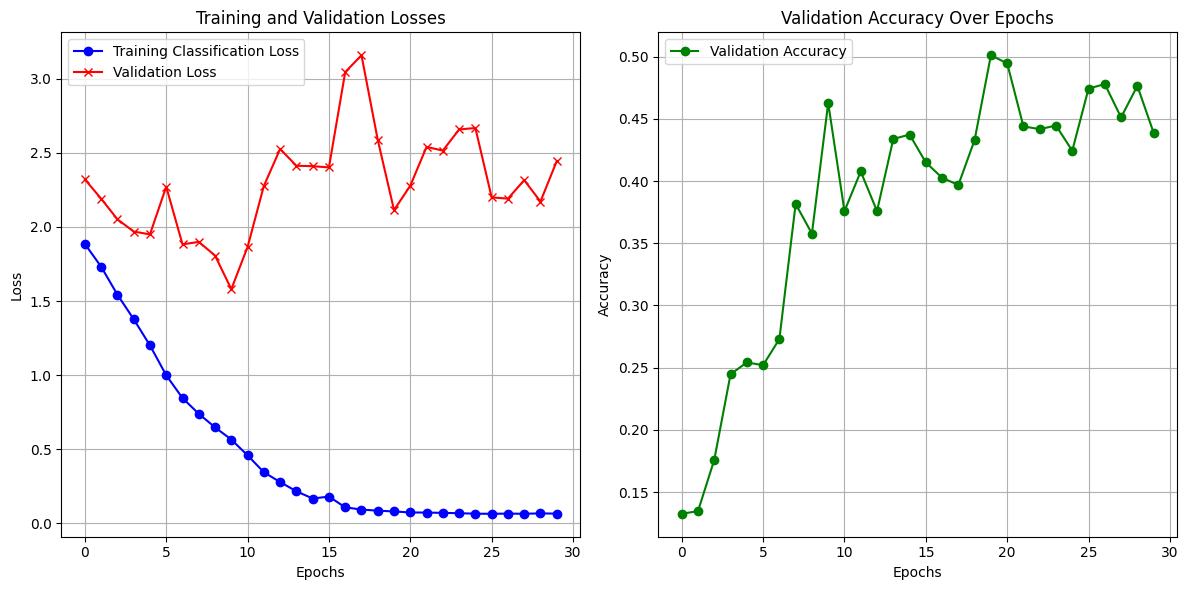

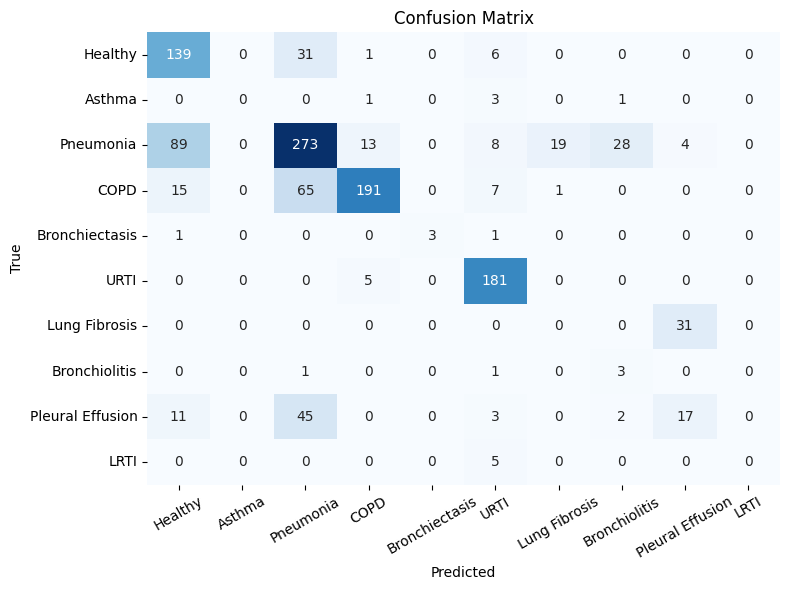

Accuracy: 0.6697
Precision: 0.4365
Recall: 0.449
F1 Score: 0.4134

Test Classification Report:
                  precision    recall  f1-score   support

         Healthy       0.55      0.79      0.64       177
          Asthma       0.00      0.00      0.00         5
       Pneumonia       0.66      0.63      0.64       434
            COPD       0.91      0.68      0.78       279
  Bronchiectasis       1.00      0.60      0.75         5
            URTI       0.84      0.97      0.90       186
   Lung Fibrosis       0.00      0.00      0.00        31
   Bronchiolitis       0.09      0.60      0.15         5
Pleural Effusion       0.33      0.22      0.26        78
            LRTI       0.00      0.00      0.00         5

        accuracy                           0.67      1205
       macro avg       0.44      0.45      0.41      1205
    weighted avg       0.68      0.67      0.67      1205



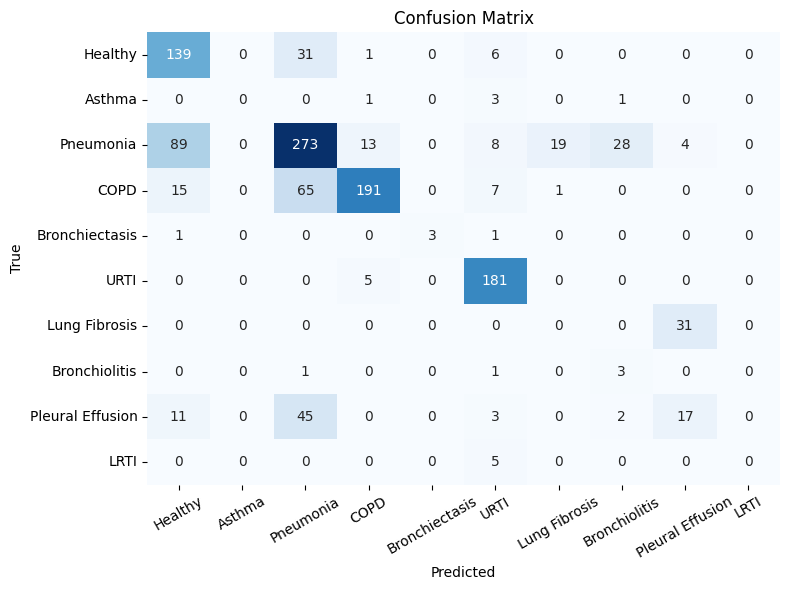

Test Accuracy for DenseNet121: 0.6697095435684647
F1 Score for DenseNet121: 0.41343476534185086


In [26]:

# Train and evaluate DenseNet121
print("\nTraining DenseNet121...")
model_densenet121 = DenseNet121_Features( num_classes=10).to(device)
optimizer_densenet121 = optim.AdamW(model_densenet121.parameters(), lr=5e-5, weight_decay=1e-5)

scheduler_densenet121 = ReduceLROnPlateau(optimizer_densenet121, mode='min', patience=5, factor=0.1)
criterion_densenet121 = nn.CrossEntropyLoss(weight=weights_tensor)



train_model(
    model=model_densenet121,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,  # Ensure your actual test_loader DataLoader is passed here
    criterion=criterion_densenet121,
    optimizer=optimizer_densenet121,
    scheduler=scheduler_densenet121,
    num_epochs=num_epochs,
    patience=patience,
    device=device,           # Make sure 'device' is also passed if you're using it
    class_names=class_names,
    lambda_coral=1.4       # You can explicitly set lambda_coral if desired
)
test_acc_densenet121,f1_densenet121 = evaluate_model(model_densenet121, test_loader,device, class_names)
print(f"Test Accuracy for DenseNet121: {test_acc_densenet121}")
print(f"F1 Score for DenseNet121: {f1_densenet121}")

###Metrics Dataframe

In [27]:
# Create the metrics list for multiple models
metrics_list = [
    {'Model': 'CustomCNN', 'Test Accuracy': test_acc_customcnn, 'F1 Score': f1_customcnn},
    {'Model': 'ResNet50', 'Test Accuracy': test_acc_resnet50, 'F1 Score': f1_resnet50},
    {'Model': 'DenseNet121', 'Test Accuracy': test_acc_densenet121, 'F1 Score': f1_densenet121},
]

# Convert the metrics list to a DataFrame
metrics_df = pd.DataFrame(metrics_list)

# Display the DataFrame
metrics_df



,Model,Test Accuracy,F1 Score
0,CustomCNN,0.609959,0.550080
1,ResNet50,0.676349,0.522673
2,DenseNet121,0.669710,0.413435


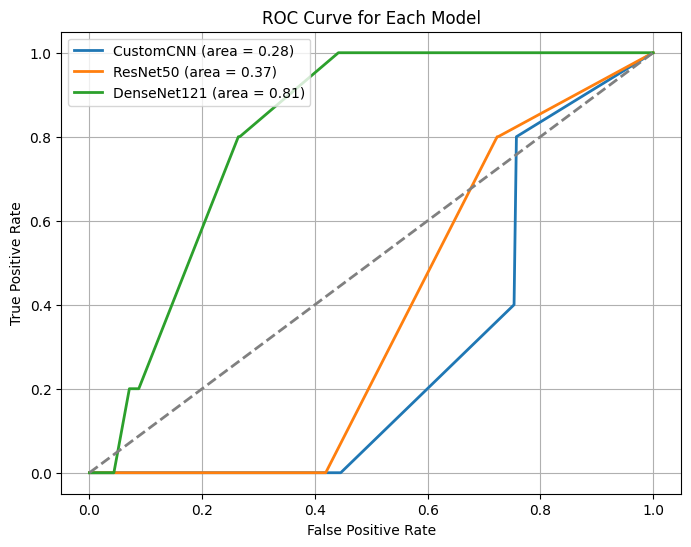

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot ROC Curve for Individual Models and Label Pretrained Model Names
def plot_individual_roc_curves(models, model_names, test_loader, device):
    plt.figure(figsize=(8, 6))

    # Iterate over the models and plot each ROC curve with its corresponding name
    for model, model_name in zip(models, model_names):
        model.eval()
        test_labels = []
        test_preds = []

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                test_labels.extend(labels.cpu().numpy())
                test_preds.extend(preds.cpu().numpy())

        # Compute ROC curve for the current model
        fpr, tpr, _ = roc_curve(test_labels, test_preds, pos_label=1)
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve for the current model, using the model name in the label
        plt.plot(fpr, tpr, lw=2, label=f'{model_name} (area = {roc_auc:.2f})')

    # Plot diagonal line for random classifier
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Each Model')
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.show()

# Now plot the ROC curves for each model
# Assuming you have the trained models in the list 'models'
models = [custom_cnn_model, model_resnet50,model_densenet121]
model_names = ['CustomCNN', 'ResNet50', 'DenseNet121']
plot_individual_roc_curves(models, model_names, test_loader, device)
